# NFL Punt Analytics Analysis
## Reducing Injuries while 
Rob Mulla

The NFL Punt Analytics Competition is being held by the NFL to elicit the public's proposal for rule modfications to punt rules. The goal being to reduce injuries.

Submissions will be judged by the NFL on the following criteria:

- **Solution Efficacy** - Have you clearly demonstrated, through your data analysis, that you have an understanding of what play features may be associated with concussions and how your proposed rule change(s) will reduce these injuries? Your kernels should be easy to understand and the analysis should be reproducible.  
- **Game Integrity** - Is your proposal actionable by the NFL? Could they implement your rule change and still maintain the integrity of the game? Have you considered the way your proposed changes to game dynamics could introduce new risks to player safety? Strong submissions will demonstrate an understanding for the game overall.

## Outline
1. **Data Analysis of All Punts**
    - What types of punts are common
    - What distance
    - What are the common formations for punts and punt returns?
2. **Data Analysis of Punts resulting in injury**
    - Which players are commonly involved in injuries?
    - What are the types of returns which result in injuries?
        - Can we group these? (ie., fake punt, long return, quick return, etc.)
    - What are the speed and velocity of players hurt?
3. **What are the routes run by player types?**
4. **What are possible changes to rules- how do they impact the plays?**
5. **My proposed rule changes**
    - How would they have changed the injuries?
    - How would they have changed the existing plays?

## Setup and Data Prep

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os

import bokeh        
from bokeh.io import show, output_notebook, push_notebook
from bokeh.layouts import row, column, widgetbox
from bokeh.plotting import figure
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
from bokeh.models import BoxAnnotation
from bokeh.models.widgets import Div
from bokeh.models.glyphs import Text

%matplotlib inline

In [160]:
# Read in non-NGS data sources
ppd = pd.read_csv('../input/player_punt_data.csv')
gd = pd.read_csv('../input/game_data.csv')
pprd = pd.read_csv('../input/play_player_role_data.csv')
vr = pd.read_csv('../input/video_review.csv')
vfi = pd.read_csv('../input/video_footage-injury.csv')
pi = pd.read_csv('../input/play_information.csv')

all_dfs = [ppd, gd, pprd, vr, vfi, pi]
for mydf in all_dfs:
    mydf.columns = [col.lower() for col in mydf.columns]

In [ ]:
%%time
read_ngs_data = True # Set to true to read NGS data (takes time and uses a lot of memory)
# Read in NGS data and combine.
# First try to read parquet file if it exists
def load_NGS_df(path = "../input/"):
    
    # gets all csv with NGS in their filename
    NGS_csvs = [path+file for file in os.listdir(path) if 'NGS' in file]
    
    df = pd.DataFrame() #initialize an empty dataframe
    
    # loop to csv then appends it to df
    for path_csv in NGS_csvs:
        _df = pd.read_csv(path_csv,low_memory=False)
        df = df.append(_df,ignore_index=True)
        del _df # deletes the _df to free up memory
        
    return df

if read_ngs_data:
    try:
        ngs = pd.read_parquet('../input/ngs_combined_with_role_lssnap.parquet')
    except:
        print('No parquet file- reading from CSVs')
        ngs = load_NGS_df()
        ngs.columns = [col.lower() for col in ngs.columns]
        ngs = pd.merge(ngs, pprd) # Merge player position data
        # Add rows for long snapper position at snap (for reference x,y)
        ngs_ls_at_snap = ngs.loc[(ngs['event'] == 'ball_snap') &
                             (ngs['role'] == 'PLS')]

        ngs = pd.merge(ngs,
                   ngs_ls_at_snap[['season_year','gamekey','playid','time','x','y']],
                   on=['season_year','gamekey','playid'],
                   how='left',
                   suffixes=('','_ls_at_snap'))
        ngs.to_parquet('../input/ngs_combined_with_role_lssnap.parquet')

In [ ]:
# Detailed role info
role_info_dict = {'GL': ['Gunner', 'Punting_Team'],
             'GLi': ['Gunner', 'Punting_Team'],
             'GLo': ['Gunner', 'Punting_Team'],
             'GR': ['Gunner', 'Punting_Team'],
             'GRi': ['Gunner', 'Punting_Team'],
             'GRo': ['Gunner', 'Punting_Team'],
             'P': ['Punter', 'Punting_Team'],
             'PC': ['Punter_Protector', 'Punting_Team'],
             'PPR': ['Punter_Protector', 'Punting_Team'],
             'PPRi': ['Punter_Protector', 'Punting_Team'],
             'PPRo': ['Punter_Protector', 'Punting_Team'],
             'PDL1': ['Defensive_Lineman', 'Returning_Team'],
             'PDL2': ['Defensive_Lineman', 'Returning_Team'],
             'PDL3': ['Defensive_Lineman', 'Returning_Team'],
             'PDR1': ['Defensive_Lineman', 'Returning_Team'],
             'PDR2': ['Defensive_Lineman', 'Returning_Team'],
             'PDR3': ['Defensive_Lineman', 'Returning_Team'],
             'PDL5': ['Defensive_Lineman', 'Returning_Team'],
             'PDL6': ['Defensive_Lineman', 'Returning_Team'],
             'PFB': ['PuntFullBack', 'Punting_Team'],
             'PLG': ['Punting_Lineman', 'Punting_Team'],
             'PLL': ['Defensive_Backer', 'Returning_Team'],
             'PLL1': ['Defensive_Backer', 'Returning_Team'],
             'PLL3': ['Defensive_Backer', 'Returning_Team'],
             'PLS': ['Punting_Longsnapper', 'Punting_Team'],
             'PLT': ['Punting_Lineman', 'Punting_Team'],
             'PLW': ['Punting_Wing', 'Punting_Team'],
             'PRW': ['Punting_Wing', 'Punting_Team'],
             'PR': ['Punt_Returner', 'Returning_Team'],
             'PRG': ['Punting_Lineman', 'Punting_Team'],
             'PRT': ['Punting_Lineman', 'Punting_Team'],
             'VLo': ['Jammer', 'Returning_Team'],
             'VR': ['Jammer', 'Returning_Team'],
             'VL': ['Jammer', 'Returning_Team'],
             'VRo': ['Jammer', 'Returning_Team'],
             'VRi': ['Jammer', 'Returning_Team'],
             'VLi': ['Jammer', 'Returning_Team'],
             'PPL': ['Punter_Protector', 'Punting_Team'],
             'PPLo': ['Punter_Protector', 'Punting_Team'],
             'PPLi': ['Punter_Protector', 'Punting_Team'],
             'PLR': ['Defensive_Backer', 'Returning_Team'],
             'PRRo': ['Defensive_Backer', 'Returning_Team'],
             'PDL4': ['Defensive_Lineman', 'Returning_Team'],
             'PDR4': ['Defensive_Lineman', 'Returning_Team'],
             'PLM': ['Defensive_Backer', 'Returning_Team'],
             'PLM1': ['Defensive_Backer', 'Returning_Team'],
             'PLR1': ['Defensive_Backer', 'Returning_Team'],
             'PLR2': ['Defensive_Backer', 'Returning_Team'],
             'PLR3': ['Defensive_Backer', 'Returning_Team'],
             'PLL2': ['Defensive_Backer', 'Returning_Team'],
             'PDM': ['Defensive_Lineman', 'Returning_Team'],
             'PDR5': ['Defensive_Lineman', 'Returning_Team'],
             'PDR6': ['Defensive_Lineman', 'Returning_Team'],
             }
role_info = pd.DataFrame.from_dict(role_info_dict, orient='index', columns=['generalized_role','punting_returning_team']).reset_index().rename(columns={'index' : 'role'})
#ngs = pd.merge(ngs, role_info, how='left')

# Types of Punting Plays
6681 Different Plays provided information.

## Penalties
- 1077 Plays with Penalties (16.1%)
- Multiple Penalties:
    - 1038 plays have 1 type of penalty, 38 have 2 types of pentalties, and 1 play has 3 types of penalties.
- Most common penalty is `Offensive Holding` 442 of plays (6.6% of all punting plays) result in **Offensive Holding**
- **Illegal Blocking Above the Waist** is second most common penalty with 227 (3.39% of all punting plays)
- 243 plays (3.63% of punting plays) ended up not actually counting - ie a `No Play`
- 16 Plays were reviewed and had the call of field REVERSED
- 99 penalties declined
- There was a punting play with 5 total penalties! https://www.ninersnation.com/2017/8/19/16175124/referee-laughs-five-penalties-49ers-broncos-punt-pete-morelli

In [ ]:
# Penalties

penalties_list = ['Offensive Holding', 'Defensive 12 On-field', 'Illegal Block Above the Waist', 'Fair Catch Interference',
                  'Running Into the Kicker', 'Unnecessary Roughness', 'Illegal Touch Kick',
                  'Illegal Use of Hands', 'False Start', 'Out of Bounds on Punt', 'Horse Collar Tackle',
                  'Face Mask', 'Ineligible Downfield Kick', 'Illegal Substitution', 'Illegal Formation',
                  'Delay of Game', 'Illegal Blindside Block', 'Neutral Zone Infraction', 'Tripping',
                  'Defensive Holding', 'Roughing the Kicker', 'Unsportsmanlike Conduct', 'Defensive Offside',
                  'Interference with Opportunity to Catch', 'Illegal Motion', 'Chop Block', 'Clipping',
                  'Invalid Fair Catch Signal', 'Illegal Shift', 'Offensive 12 On-field', 'Taunting',
                  'Offensive Pass Interference', 'Disqualification', 'Defensive Pass Interference']

pi['PENALTY'] = (pi['playdescription'].str.contains('PENALTY') | pi['playdescription'].str.contains('Penalty'))
pi['declined'] = pi['playdescription'].str.contains('declined')


pi['Offensive Holding'] =  pi['playdescription'].str.contains('Offensive Holding')
pi['Defensive 12 On-field'] =  pi['playdescription'].str.contains('Defensive 12 On-field')
pi['Illegal Block Above the Waist'] =  pi['playdescription'].str.contains('Illegal Block Above the Waist')
pi['Fair Catch Interference'] = pi['playdescription'].str.contains('Fair Catch Interference')
pi['Running Into the Kicker'] = pi['playdescription'].str.contains('Running Into the Kicker')
pi['Unnecessary Roughness'] = pi['playdescription'].str.contains('Unnecessary Roughness')
pi['Illegal Touch Kick'] = pi['playdescription'].str.contains('Illegal Touch Kick')
pi['Illegal Use of Hands'] = pi['playdescription'].str.contains('Illegal Use of Hands')
pi['False Start'] = pi['playdescription'].str.contains('False Start')
pi['Out of Bounds on Punt'] = pi['playdescription'].str.contains('Out of Bounds on Punt')
pi['Horse Collar Tackle'] = pi['playdescription'].str.contains('Horse Collar Tackle')
pi['Face Mask'] = pi['playdescription'].str.contains('Face Mask')
pi['Ineligible Downfield Kick'] = pi['playdescription'].str.contains('Ineligible Downfield Kick')
pi['Illegal Substitution'] = pi['playdescription'].str.contains('Illegal Substitution')
pi['Illegal Formation'] = pi['playdescription'].str.contains('Illegal Formation')
pi['Delay of Game'] = pi['playdescription'].str.contains('Delay of Game')
pi['Illegal Blindside Block'] = pi['playdescription'].str.contains('Illegal Blindside Block')
pi['Neutral Zone Infraction'] = pi['playdescription'].str.contains('Neutral Zone Infraction')
pi['Tripping'] = pi['playdescription'].str.contains('Tripping')
pi['Defensive Holding'] = pi['playdescription'].str.contains('Defensive Holding')
pi['Roughing the Kicker'] = pi['playdescription'].str.contains('Roughing the Kicker')
pi['Unsportsmanlike Conduct'] = pi['playdescription'].str.contains('Unsportsmanlike Conduct')
pi['Defensive Offside'] = pi['playdescription'].str.contains('Defensive Offside')
pi['Interference with Opportunity to Catch'] = pi['playdescription'].str.contains('Interference with Opportunity to Catch')
pi['Illegal Motion'] = pi['playdescription'].str.contains('Illegal Motion')
pi['Chop Block'] = pi['playdescription'].str.contains('Chop Block')
pi['Clipping'] = pi['playdescription'].str.contains('Clipping')
pi['Invalid Fair Catch Signal'] = pi['playdescription'].str.contains('Invalid Fair Catch Signal')
pi['Illegal Shift'] = pi['playdescription'].str.contains('Illegal Shift')
pi['Offensive 12 On-field'] = pi['playdescription'].str.contains('Offensive 12 On-field')
pi['Taunting'] = pi['playdescription'].str.contains('Taunting')
pi['Offensive Pass Interference'] = pi['playdescription'].str.contains('Offensive Pass Interference')
pi['Disqualification'] = pi['playdescription'].str.contains('Disqualification')
pi['Defensive Pass Interference'] = pi['playdescription'].str.contains('Defensive Pass Interference')

pi['count'] = 1

# Plot Penalties

ax = pi[penalties_list].sum() \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 10), color='grey', title='Punting Play Penalty Types')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

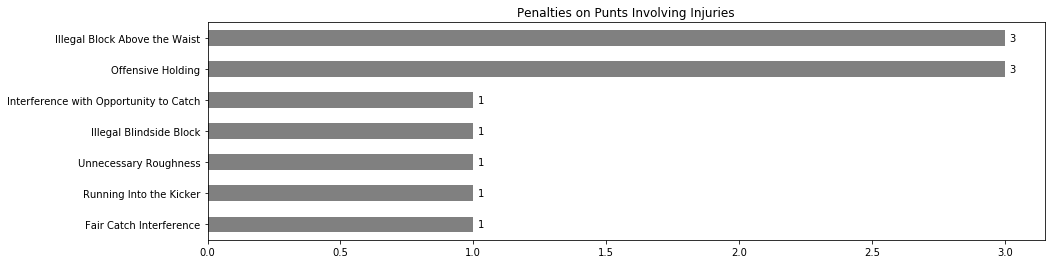

In [7]:
injury_plays = pd.merge(pi, vr)

ax = injury_plays[penalties_list].sum().loc[(injury_plays[penalties_list].sum() != 0)] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 4), color='grey', title='Penalties on Punts Involving Injuries')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

## No Plays (Penalty Causing the play not to count)

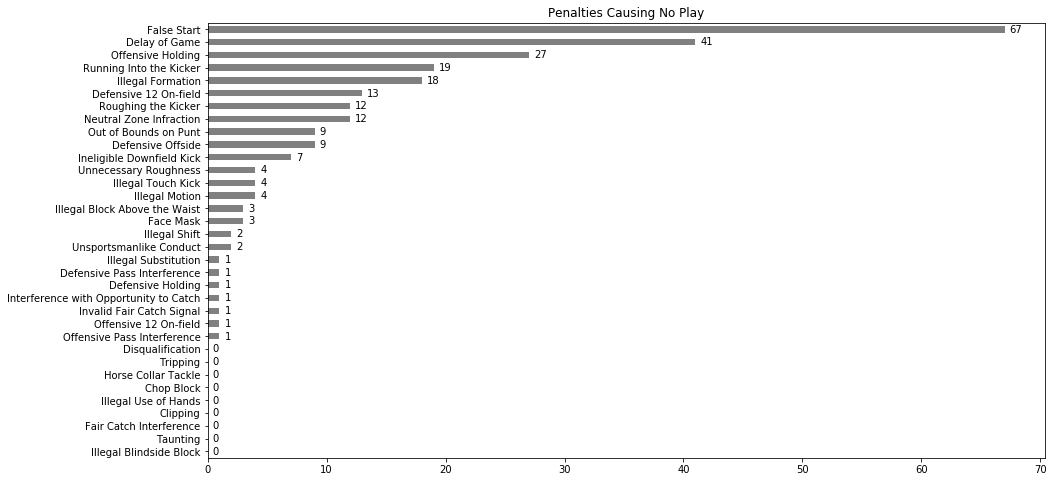

In [8]:
pi['No Play'] = pi['playdescription'].str.contains('No Play')
ax = pi[pi['No Play']][penalties_list].sum() \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), color='grey', title='Penalties Causing No Play')
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

## Reviewed / Reversed Plays
- 41 Punting plays had some sort of review.
    - 23 of the reviews were by challenge
    - 18 plays reviewed by the Replay Official
- 52.1% of challeneged plays were reversed
- 22.2% of reviewed by Replay Official reversed

In [9]:
pi['challenged'] = pi['playdescription'].str.contains('challenged')
pi['review'] = pi['playdescription'].str.contains('review')
pi['Upheld'] = pi['playdescription'].str.contains('Upheld')
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')

pi[pi['challenged'] | pi['review']] \
    .groupby(['challenged'])[['Upheld','REVERSED']] \
    .sum() \
    .sort_values('challenged', ascending=False)

Upheld  REVERSED
challenged                  
True          11.0      12.0
False         14.0       4.0

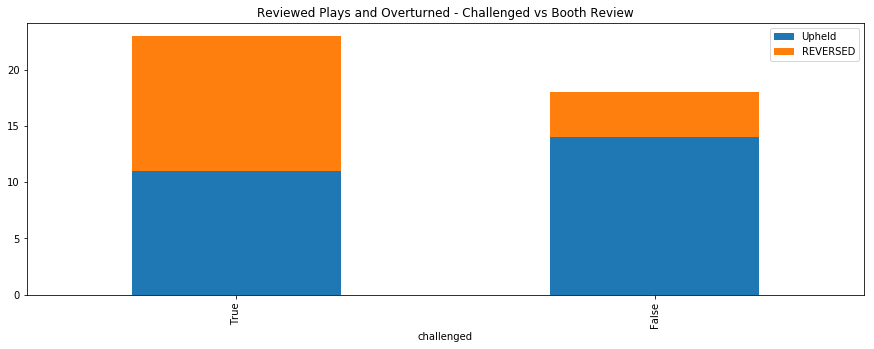

In [10]:
pi['challenged'] = pi['playdescription'].str.contains('challenged')
pi['review'] = pi['playdescription'].str.contains('review')
pi['Upheld'] = pi['playdescription'].str.contains('Upheld')
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')

pi[pi['challenged'] | pi['review']] \
    .groupby(['challenged'])[['Upheld','REVERSED']] \
    .sum() \
    .sort_values('challenged', ascending=False) \
    .plot(kind='bar', stacked='True', figsize=(15, 5), title='Reviewed Plays and Overturned - Challenged vs Booth Review')

plt.show()

# Fair Catch, Touchback, Out of Bounds or Returned

In [11]:
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')
pi['out of bounds'] = pi['playdescription'].str.contains('out of bounds')
pi['Touchback'] = pi['playdescription'].str.contains('Touchback')
pi['fair catch'] = pi['playdescription'].str.contains('fair catch')
pi['MUFF'] = pi['playdescription'].str.contains('MUFF')
pi['downed'] = pi['playdescription'].str.contains('downed')
pi['BLOCKED'] = pi['playdescription'].str.contains('BLOCKED')
pi['TOUCHDOWN'] = pi['playdescription'].str.contains('TOUCHDOWN')
pi['no gain'] = pi['playdescription'].str.contains('no gain')
pi['FUMBLES'] = pi['playdescription'].str.contains('FUMBLES')
pi['pass incomplete'] = pi['playdescription'].str.contains('pass incomplete')

pi['Returned'] = (~pi['No Play'] &
                    ~pi['out of bounds'] &
                    ~pi['Touchback'] &
                    ~pi['fair catch'] &
                    ~pi['downed'] &
                    ~pi['MUFF'] &
                    ~pi['BLOCKED'] &
                    ~pi['PENALTY'] &
                    ~pi['no gain'] &
                    ~pi['FUMBLES'] &
                    ~pi['pass incomplete'])

pi['returned for'] = pi[~pi['No Play'] &
                        ~pi['out of bounds'] &
                        ~pi['Touchback'] &
                        ~pi['fair catch'] &
                        ~pi['downed'] &
                        ~pi['MUFF'] &
                        ~pi['BLOCKED'] &
                        ~pi['PENALTY'] &
                        ~pi['no gain'] &
                        ~pi['FUMBLES'] &
                        ~pi['pass incomplete']]['playdescription'].str.extract('(for .* yard)', expand=True).fillna(False)

# Cleanup ugly retrun yards and get int
pi['return_yards'] = pi['returned for'].replace('for -2 yards. Lateral to C.Patterson to MIN 31 for 9 yards (W.Woodyard', 'for 9 yards') \
    .replace('for -4 yards. Lateral to R.Mostert to SEA 35 for 33 yard', 'for 33 yard') \
    .replace('for 10 yards (K.Byard', 'for 11 yard') \
    .replace('for 12 yards (A.Blake; W.Woodyard','for 12 yard') \
    .replace('for 14 yards (N.Palmer; K.Byard','for 14 yard') \
    .replace('for 44 yards (R.Blanton; C.Schmidt). Buffalo challenged the runner was in bounds ruling, and the play was REVERSED. C.Schmidt punts 35 yards to SEA 38, Center-G.Sanborn. T.Lockett ran ob at BUF 40 for 22 yard', 'for 22 yard') \
    .replace('for 2 yards (W.Woodyard','for 2 yard') \
    .replace('for -2 yards. Lateral to C.Patterson to MIN 31 for 9 yard','for 9 yard') \
    .replace('for 34 yards (C.Goodwin). Atlanta challenged the runner was in bounds ruling, and the play was REVERSED. M.Bosher punts 56 yards to NE 21, Center-J.Harris. J.Edelman ran ob at NE 47 for 26 yard', 'for 26 yard') \
    .dropna() \
    .str.replace('for ','').str.replace('yard','').astype('int')
# Zero return yards for 'no gain'
pi.loc[pi['no gain'], 'return_yards'] = 0

In [12]:
pi.loc[3400]['playdescription']

'(10:20) B.Pinion punts 56 yards to KC 26, Center-K.Nelson. D.Thomas pushed ob at KC 35 for 9 yards (D.Smelter). PENALTY on KC-J.March-Lillard, Offensive Holding, 10 yards, enforced at KC 27.'

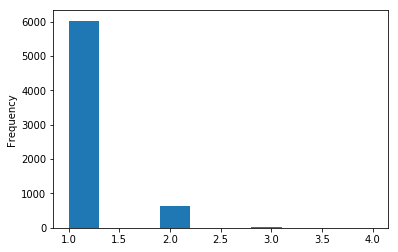

In [13]:
pi[['Returned',
    'PENALTY',
    'out of bounds',
    'FUMBLES',
    'Touchback',
    'fair catch',
    'MUFF',
    'downed',
    'BLOCKED',
    'no gain',
    'pass incomplete']] \
    .sum(axis=1) \
    .sort_values() \
    .plot(kind='hist')

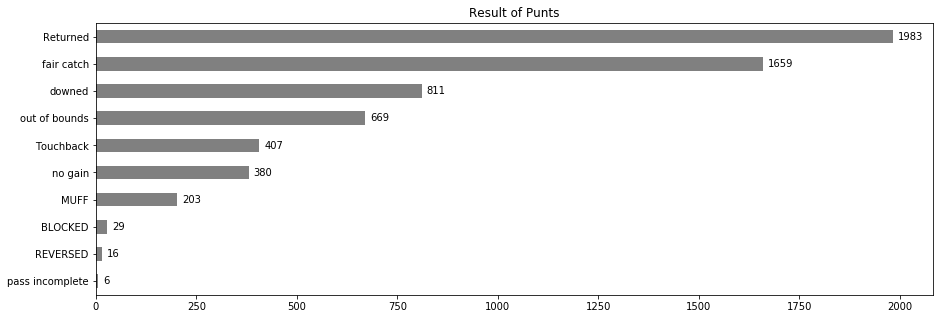

In [14]:
ax = pi[['Returned', 'REVERSED','out of bounds','Touchback','fair catch','MUFF','downed','BLOCKED','no gain','pass incomplete']] \
    .sum() \
    .sort_values(ascending=True) \
    .plot(kind='barh', color='grey', figsize=(15, 5), title='Result of Punts')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

# Typical Return Yards

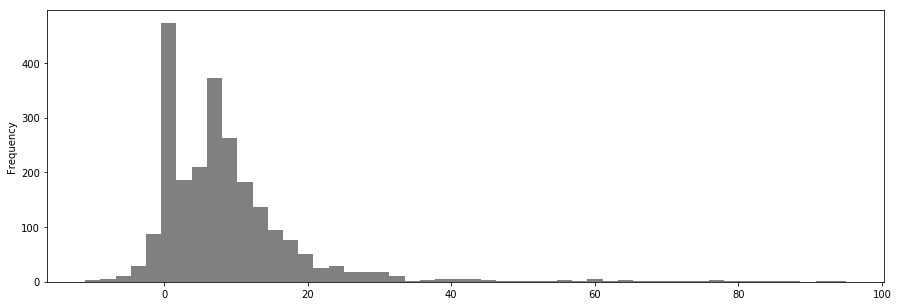

In [15]:
pi['return_yards'].plot(kind='hist', figsize=(15, 5), bins=50, color='grey')

In [16]:
print('Median return is for : {:.2f} yards'.format(pi['return_yards'].median()))
print('Mean return is for   : {:.2f} yards'.format(pi['return_yards'].mean()))

Median return is for : 7.00 yards
Mean return is for   : 8.80 yards


# Typical Result of Injured Plays

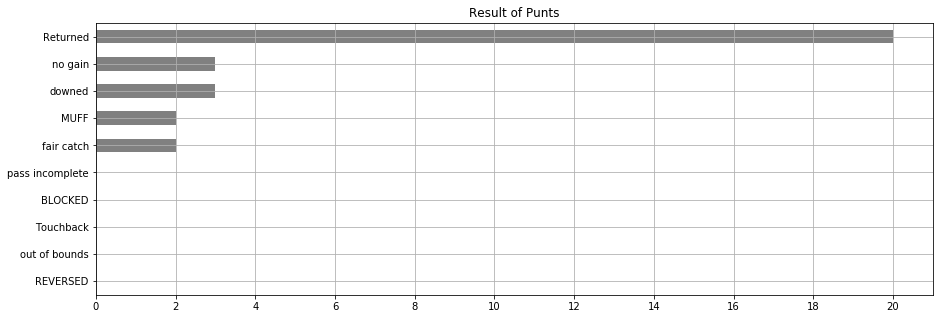

In [18]:
ax = pd.merge(pi, vr, on=['season_year', 'playid', 'gamekey'])[['Returned', 'REVERSED','out of bounds','Touchback','fair catch','MUFF','downed','BLOCKED','no gain','pass incomplete']] \
    .sum() \
    .sort_values(ascending=True) \
    .plot(kind='barh', color='grey', figsize=(15, 5), title='Result of Punts', grid=True)

major_ticks = np.arange(0, 22, 2)
ax.set_xticks(major_ticks)
plt.show()

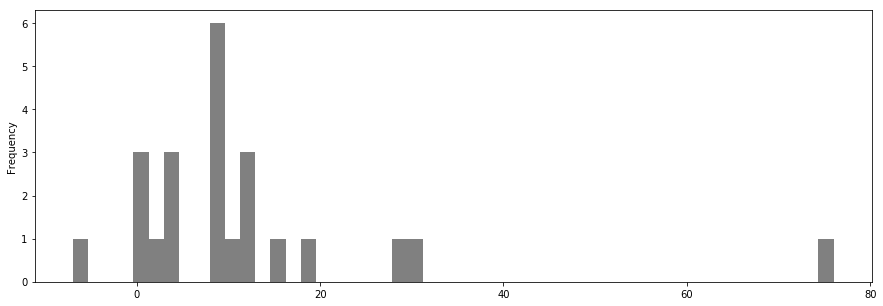

In [20]:
pd.merge(pi, vr, on=['season_year', 'playid', 'gamekey'])['return_yards'].plot(kind='hist', figsize=(15, 5), bins=50, color='grey')

In [21]:
print('Median return on a play involving an injury is for : {:.2f} yards'.format(pd.merge(pi, vr, on=['season_year', 'playid', 'gamekey'])['return_yards'].median()))
print('Mean return on a play involving an injury is for   : {:.2f} yards'.format(pd.merge(pi, vr, on=['season_year', 'playid', 'gamekey'])['return_yards'].mean()))

Median return on a play involving an injury is for : 9.00 yards
Mean return on a play involving an injury is for   : 11.87 yards


# Player Types involved in a Punt

- In this analysis we will only look at plays positions when the ball is snapped. Only players involved in the plays will be used.

In [22]:
# Read data
ballsnap_pos = pd.read_csv('../working/ballsnap_pos.csv', index_col=0)
print('orig ballsnap shape {}'.format(ballsnap_pos.shape))
pi = pd.read_csv('../input/play_information.csv')

pi.columns = [col.lower() for col in pi.columns]
ballsnap_pos['season_year'] = ballsnap_pos['season_year'].astype('int64')
ballsnap_pos['gamekey'] = ballsnap_pos['gamekey'].astype('int64')
ballsnap_pos['playid'] = ballsnap_pos['playid'].astype('int64')

# Create columns
ballsnap_pos['home_team'] = ballsnap_pos['home_team_visit_team'].str[:3]
ballsnap_pos['visit_team'] = ballsnap_pos['home_team_visit_team'].str[4:]
ballsnap_pos['yardline_int'] = ballsnap_pos['yardline'].str[-2:].astype('int')
ballsnap_pos['x_flipped'] = ballsnap_pos.apply(lambda col: 120-col['x'] if col['poss_team'] == col['home_team'] else col['x'], axis=1)
ballsnap_pos['y_flipped'] = ballsnap_pos.apply(lambda col: 53.3-col['y'] if col['poss_team'] == col['home_team'] else col['y'], axis=1)
ballsnap_pos['left_to_right'] = ballsnap_pos.apply(lambda col: True if col['poss_team'] == col['home_team'] else False, axis=1)


ballsnap_pos = pd.merge(ballsnap_pos, pi) # Merge play information
print('ballsnap shape after merging play info {}'.format(ballsnap_pos.shape))

ppd = pd.read_csv('../input/player_punt_data.csv')
ppd.columns = [col.lower() for col in ppd.columns]
ppd_numbers = ppd.groupby('gsisid')['number'].apply(', '.join).reset_index()
ppd_positions = ppd.groupby('gsisid')['position'].apply(', '.join).reset_index()
ppd_by_gsisid = pd.merge(ppd_numbers, ppd_positions)
ballsnap_pos = pd.merge(ballsnap_pos, ppd_by_gsisid, how='left')
print('ballsnap shape after merging player numbers and position info {}'.format(ballsnap_pos.shape))

pprd = pd.read_csv('../input/play_player_role_data.csv')
pprd.columns = [col.lower() for col in pprd.columns]
ballsnap_pos = pd.merge(ballsnap_pos, pprd, how='left')
print('ballsnap shape after merging player role info {}'.format(ballsnap_pos.shape))

# Role info 
role_info_dict = {'GL': ['Gunner', 'Punting_Team'],
             'GLi': ['Gunner', 'Punting_Team'],
             'GLo': ['Gunner', 'Punting_Team'],
             'GR': ['Gunner', 'Punting_Team'],
             'GRi': ['Gunner', 'Punting_Team'],
             'GRo': ['Gunner', 'Punting_Team'],
             'P': ['Punter', 'Punting_Team'],
             'PC': ['Punter_Protector', 'Punting_Team'],
             'PPR': ['Punter_Protector', 'Punting_Team'],
             'PPRi': ['Punter_Protector', 'Punting_Team'],
             'PPRo': ['Punter_Protector', 'Punting_Team'],
             'PDL1': ['Defensive_Lineman', 'Returning_Team'],
             'PDL2': ['Defensive_Lineman', 'Returning_Team'],
             'PDL3': ['Defensive_Lineman', 'Returning_Team'],
             'PDR1': ['Defensive_Lineman', 'Returning_Team'],
             'PDR2': ['Defensive_Lineman', 'Returning_Team'],
             'PDR3': ['Defensive_Lineman', 'Returning_Team'],
             'PDL5': ['Defensive_Lineman', 'Returning_Team'],
             'PDL6': ['Defensive_Lineman', 'Returning_Team'],
             'PFB': ['PuntFullBack', 'Punting_Team'],
             'PLG': ['Punting_Lineman', 'Punting_Team'],
             'PLL': ['Defensive_Backer', 'Returning_Team'],
             'PLL1': ['Defensive_Backer', 'Returning_Team'],
             'PLL3': ['Defensive_Backer', 'Returning_Team'],
             'PLS': ['Punting_Longsnapper', 'Punting_Team'],
             'PLT': ['Punting_Lineman', 'Punting_Team'],
             'PLW': ['Punting_Wing', 'Punting_Team'],
             'PRW': ['Punting_Wing', 'Punting_Team'],
             'PR': ['Punt_Returner', 'Returning_Team'],
             'PRG': ['Punting_Lineman', 'Punting_Team'],
             'PRT': ['Punting_Lineman', 'Punting_Team'],
             'VLo': ['Jammer', 'Returning_Team'],
             'VR': ['Jammer', 'Returning_Team'],
             'VL': ['Jammer', 'Returning_Team'],
             'VRo': ['Jammer', 'Returning_Team'],
             'VRi': ['Jammer', 'Returning_Team'],
             'VLi': ['Jammer', 'Returning_Team'],
             'PPL': ['Punter_Protector', 'Punting_Team'],
             'PPLo': ['Punter_Protector', 'Punting_Team'],
             'PPLi': ['Punter_Protector', 'Punting_Team'],
             'PLR': ['Defensive_Backer', 'Returning_Team'],
             'PRRo': ['Defensive_Backer', 'Returning_Team'],
             'PDL4': ['Defensive_Lineman', 'Returning_Team'],
             'PDR4': ['Defensive_Lineman', 'Returning_Team'],
             'PLM': ['Defensive_Backer', 'Returning_Team'],
             'PLM1': ['Defensive_Backer', 'Returning_Team'],
             'PLR1': ['Defensive_Backer', 'Returning_Team'],
             'PLR2': ['Defensive_Backer', 'Returning_Team'],
             'PLR3': ['Defensive_Backer', 'Returning_Team'],
             'PLL2': ['Defensive_Backer', 'Returning_Team'],
             'PDM': ['Defensive_Lineman', 'Returning_Team'],
             'PDR5': ['Defensive_Lineman', 'Returning_Team'],
             'PDR6': ['Defensive_Lineman', 'Returning_Team'],
             }
role_info = pd.DataFrame.from_dict(role_info_dict, orient='index', columns=['Generalized_Role','Punting_Returning_Team']).reset_index().rename(columns={'index' : 'role'})
ballsnap_pos = pd.merge(ballsnap_pos, role_info, how='left')
print('ballsnap shape after merging player role details {}'.format(ballsnap_pos.shape))

# Add punt return team colors
ballsnap_pos['Punting_Returning_Team_Color'] = ballsnap_pos.apply(lambda x: "#9b59b6" if x['Punting_Returning_Team'] == 'Punting_Team' else "#3498db", axis=1)

# Add the long snappers x, y positions
ballsnap_pos = pd.merge(ballsnap_pos,
         ballsnap_pos.loc[ballsnap_pos.role == 'PLS'][['season_year','gamekey','playid','x','y']],
         suffixes=('','_long_snapper'), on=['season_year','gamekey','playid'], how='left')

ballsnap_pos['x_relative_ls'] = ballsnap_pos['x_long_snapper'] - ballsnap_pos['x']
ballsnap_pos['y_relative_ls'] = ballsnap_pos['y_long_snapper'] - ballsnap_pos['y']

# Add the long snappers x, y positions
ballsnap_pos = pd.merge(ballsnap_pos,
         ballsnap_pos.loc[ballsnap_pos.role == 'PR'][['season_year','gamekey','playid','x','y']],
         suffixes=('','_punt_returner'), on=['season_year','gamekey','playid'], how='left')

# ballsnap_pos['x_relative_pr'] = ballsnap_pos['x_punt_returner'] - ballsnap_pos['x']
# ballsnap_pos['y_relative_pr'] = ballsnap_pos['y_punt_returner'] - ballsnap_pos['y']

# Determine if play is left to right
ballsnap_pos['left_to_right'] = ballsnap_pos.apply(lambda x: True if x['x_long_snapper'] < x['x_punt_returner'] else False, axis=1)
ballsnap_pos['x_relative_ls_left_to_right'] = ballsnap_pos.apply(lambda x: x['x_relative_ls'] if x['left_to_right'] else -x['x_relative_ls'], axis=1)
ballsnap_pos['y_relative_ls_left_to_right'] = ballsnap_pos.apply(lambda x: x['y_relative_ls'] if x['left_to_right'] else -x['y_relative_ls'], axis=1)

# Video review data
vr = pd.read_csv('../input/video_review.csv')
vr.columns = [col.lower() for col in vr.columns]
vr['primary_partner_gsisid'] = pd.to_numeric(vr['primary_partner_gsisid'].replace('Unclear',np.nan))

ballsnap_pos = pd.merge(ballsnap_pos, vr, how='left', on=['season_year','gamekey','playid'], suffixes=('','_video_review_details'))
ballsnap_pos = pd.merge(ballsnap_pos, vr, how='left', on=['season_year','gamekey','playid','gsisid'], suffixes=('','_hurtplayer'))
ballsnap_pos = pd.merge(ballsnap_pos,
                        vr,
                        how='left',
                        left_on=['season_year','gamekey','playid','gsisid'],
                        right_on=['season_year','gamekey','playid','primary_partner_gsisid'],
                        suffixes=('','_hurtingplayer'))

# Remove people on the sidelines
ballsnap_pos = ballsnap_pos.loc[(ballsnap_pos['x'] <= 53.3) &
                 (ballsnap_pos['x'] >= 0) & 
                 (ballsnap_pos['y'] >= 0) & 
                 (ballsnap_pos['x'] <= 120)]

orig ballsnap shape (143431, 15)
ballsnap shape after merging play info (143431, 27)
ballsnap shape after merging player numbers and position info (143431, 29)
ballsnap shape after merging player role info (143431, 30)
ballsnap shape after merging player role details (143431, 32)


# Players Involved in Injury

## Common Combinations - Insights

Interesting findings:
- Punt Returners aren't necessarily involved in injuries the most on punting plays. A common misconception is that the punt plays are dangerous just because punt returners are hit directly.
    - 13 of 37 (35.1%) of plays with injuries involve the punt return
    - 5 of 37 (13.51%) plays the punt returner is the injured player
- The most common injury combination is a coverage team lineman being injured by the punt returner (4 of 37)
- Friendly fire injuries occured 6 of 37 times. These are always injuries to the punting team.
- Punting team linemen are the most commonly injured.
    - Punting Team Linemen are injured 12 of the 37 plays.
    - Punting Team linemen are the primary partner in 7 of 37 plays.
- Most common combination is 

## Generalized Role

In [116]:
ri = pd.read_csv('../working/role_info.csv', index_col=[0])

In [117]:
vr_merged = pd.merge(vr, pprd)
vr_merged = pd.merge(vr_merged, ri)

vr_merged = pd.merge(vr_merged, pprd, left_on=['season_year','gamekey','playid','primary_partner_gsisid'],
                     right_on=['season_year','gamekey','playid', 'gsisid'], how='left',
                     suffixes=('', '_primary_partner'))
vr_merged = pd.merge(vr_merged, ri, left_on='role_primary_partner', right_on='role', how='left', suffixes=('','_primary_partner'))

vr_merged = vr_merged.fillna('None')
vr_merged['count'] = 1

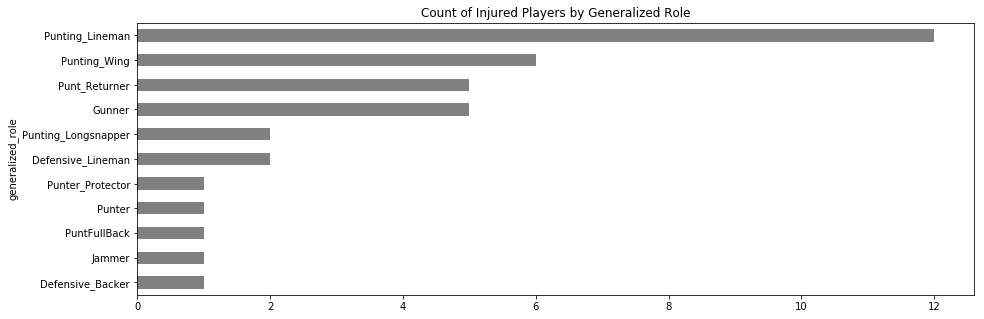

In [118]:
vr_merged.groupby('generalized_role') \
    .sum()['count'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), color='grey', title='Count of Injured Players by Generalized Role')
plt.show()

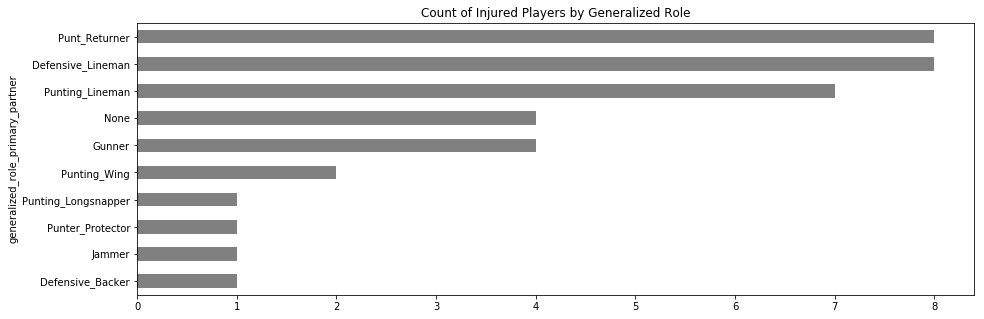

In [107]:
vr_merged.groupby('generalized_role_primary_partner') \
    .sum()['count'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), color='grey', title='Count of Injured Players by Generalized Role')
plt.show()

## Player Roles involved in injury - either primary partner or injured

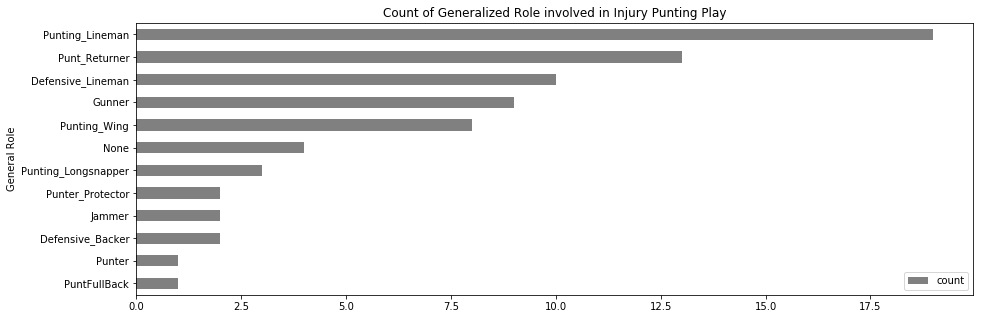

In [143]:
general_role_count = pd.DataFrame(pd.concat([vr_merged['generalized_role'],
                                             vr_merged['generalized_role_primary_partner']])) \
    .rename(columns={0 : 'General Role'})
general_role_count['count'] = 1
general_role_count.groupby('General Role') \
    .sum() \
    .sort_values('count') \
    .plot(kind='barh', figsize=(15, 5), color='grey', title='Count of Generalized Role involved in Injury Punting Play')
plt.show()

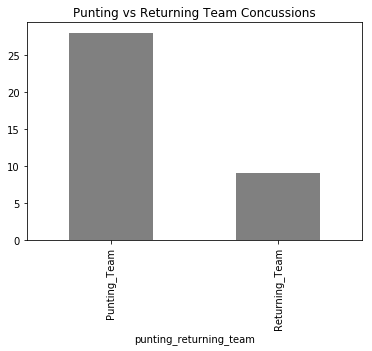

In [108]:
vr_merged.groupby('punting_returning_team').count()['count'].plot(kind='bar',
                                                                  title='Punting vs Returning Team Concussions',
                                                                  color='grey')

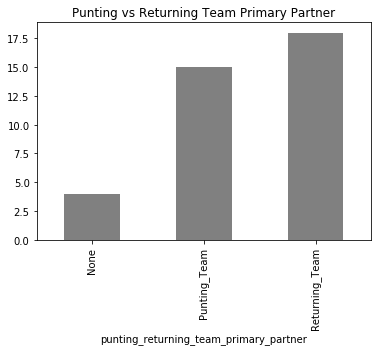

In [109]:
vr_merged.groupby('punting_returning_team_primary_partner').count()['count'].plot(kind='bar', title='Punting vs Returning Team Primary Partner', color='grey')

In [156]:
vr_merged.groupby(['generalized_role_primary_partner','generalized_role']) \
    .sum()['count'] \
    .reset_index() \
    .sort_values('count', ascending=False)

generalized_role_primary_partner     generalized_role  count
14                    Punt_Returner      Punting_Lineman      4
2                 Defensive_Lineman      Punting_Lineman      3
4                 Defensive_Lineman         Punting_Wing      3
13                    Punt_Returner               Gunner      2
12                             None         Punting_Wing      2
21                  Punting_Lineman        Punt_Returner      2
25                     Punting_Wing      Punting_Lineman      2
7                            Gunner        Punt_Returner      1
17                 Punter_Protector        Punt_Returner      1
24              Punting_Longsnapper    Defensive_Lineman      1
23                  Punting_Lineman      Punting_Lineman      1
22                  Punting_Lineman     Punter_Protector      1
3                 Defensive_Lineman  Punting_Longsnapper      1
20                  Punting_Lineman         PuntFullBack      1
19                  Punting_Lineman               Jammer      1
18                  Punting_Lineman    Defensive_Lineman      1
16                    Punt_Returner         Punting_Wing      1
8                            Gunner      Punting_Lineman      1
15                    Punt_Returner  Punting_Longsnapper      1
5                            Gunner     Defensive_Backer      1
1                 Defensive_Lineman               Gunner      1
6                            Gunner               Gunner      1
11                             None      Punting_Lineman      1
10                             None        Punt_Returner      1
9                            Jammer               Punter      1
0                  Defensive_Backer               Gunner      1

# Punting Team Common Formations

In [23]:
ballsnap_pos.loc[(ballsnap_pos['Punting_Returning_Team'] == 'Punting_Team') &
                 (ballsnap_pos['role'] == 'PRW')][['role','x','y',
                                                   'x_relative_ls_left_to_right','y_relative_ls_left_to_right',
                                                   'gamekey','season_year','playid']] \
    .sort_values('y_relative_ls_left_to_right') \
    .head()

role          x          y  x_relative_ls_left_to_right  \
48541   PRW  40.360001  30.049999                    20.899998   
49952   PRW  49.520000  59.950001                   -19.290001   
48260   PRW  27.350000  27.010000                    27.199999   
90138   PRW  39.970001  26.510000                    -3.500000   
115455  PRW  43.160000  24.080000                    -3.849998   

        y_relative_ls_left_to_right  gamekey  season_year  playid  
48541                    -33.919999      114         2016     527  
49952                    -30.160000      114         2016    2946  
48260                    -30.020000      114         2016    2583  
90138                     -3.350000      158         2016    1472  
115455                    -3.120001      300         2016    4422

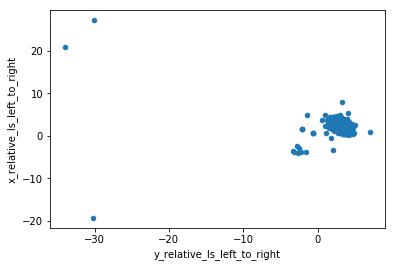

In [24]:
ballsnap_pos.loc[(ballsnap_pos['Punting_Returning_Team'] == 'Punting_Team') &
                 (ballsnap_pos['role'] == 'PRW')][['role','x','y',
                                                   'x_relative_ls_left_to_right','y_relative_ls_left_to_right']] \
    .plot('y_relative_ls_left_to_right', 'x_relative_ls_left_to_right', kind='scatter')

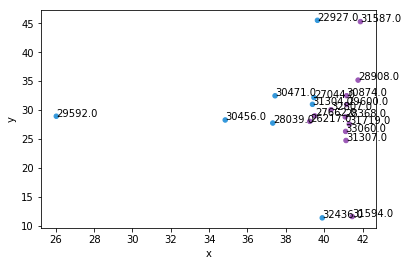

In [25]:
df = ballsnap_pos.loc[(ballsnap_pos['season_year'] == 2016) &
                 (ballsnap_pos['gamekey'] == 114) &
                (ballsnap_pos['playid'] == 527)][['x','y','role','gsisid']]

ax = df.plot('x', 'y', kind='scatter', c=ballsnap_pos['Punting_Returning_Team_Color'])

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))
        
label_point(df['x'], df['y'], df['gsisid'], ax)

In [26]:
pi.loc[(pi['season_year'] == 2016) &
         (pi['gamekey'] == 114) &
         (pi['playid'] == 527)]['playdescription'].values

array(['(7:45) K.Huber punts 48 yards to MIA 21, Center-C.Harris. J.Grant pushed ob at MIA 22 for 1 yard (J.Shaw).'],
      dtype=object)

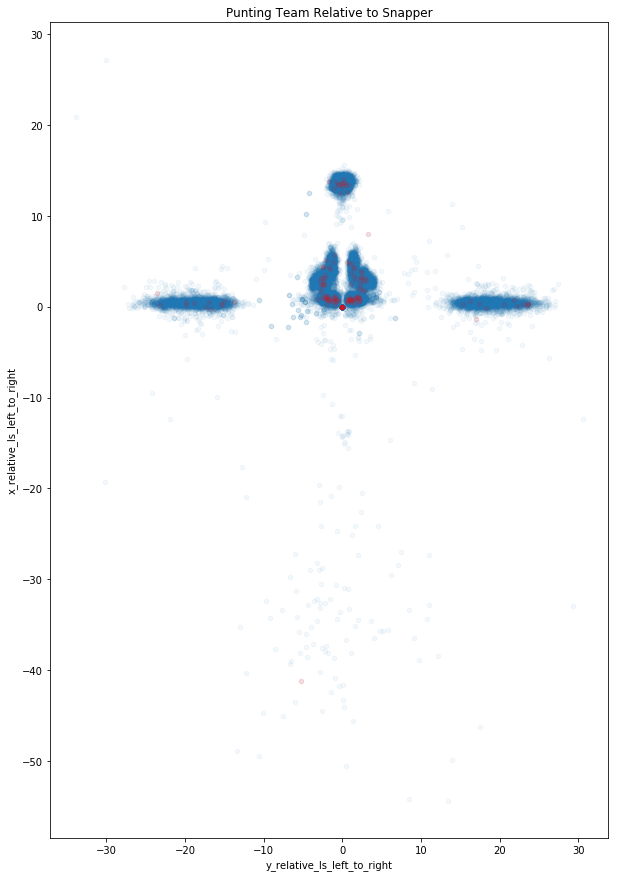

In [27]:
ax = ballsnap_pos.loc[ballsnap_pos['Punting_Returning_Team'] == 'Punting_Team'] \
    .plot('y_relative_ls_left_to_right',
          'x_relative_ls_left_to_right',
          kind='scatter',
          alpha=0.05,
          figsize=(10,15),
         title='Punting Team Relative to Snapper')

pd.merge(ballsnap_pos.loc[ballsnap_pos['Punting_Returning_Team'] == 'Punting_Team'], vr, on =['season_year','gamekey','playid']).plot(x='y_relative_ls_left_to_right',
                  y='x_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                          color='r',
                          ax = ax)
plt.show()

In [158]:
ax = ballsnap_pos.loc[ballsnap_pos['Punting_Returning_Team'] == 'Returning_Team'].plot('y_relative_ls_left_to_right', 'x_relative_ls_left_to_right', kind='scatter', alpha=0.01, figsize=(10, 15), title='Returning Team Relative to Snapper')
pd.merge(ballsnap_pos.loc[ballsnap_pos['Punting_Returning_Team'] == 'Returning_Team'], vr, on =['season_year','gamekey','playid']).plot(x='y_relative_ls_left_to_right',
                  y='x_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                          color='r',
                          ax = ax)
plt.show()

NameError: name 'ballsnap_pos' is not defined

# Find the Point when Injuries Occur

In [38]:
season_year = 2016
gamekey = 231
playid = 1976

vfi.loc[(vfi['season'] == season_year) &
       (vfi['gamekey'] == gamekey) &
       (vfi['playid'] == playid)]

season type  week         home_team          visit_team  qtr  \
11    2016  Reg    12  Baltimore Ravens  Cincinnati Bengals    2   

                                      playdescription  gamekey  playid  \
11  (1:15) (Punt formation) K.Huber punts 58 yards...      231    1976   

                                 preview link (5000k)  
11  https://nfl-vod.cdn.anvato.net/league/5691/18/...

In [45]:
season_year = 2016
gamekey = 231
playid = 1976
from IPython.core.display import display, HTML

def plot_injured_play(season_year, gamekey, playid):
    """
    Plots for a play where players are injured
    Shows path of injured player, punt returner, and injuring player.
    Also shows position when ball is snapped
    """
    play = ngs.loc[(ngs['season_year'] == season_year) &
            (ngs['gamekey'] == gamekey) &
            (ngs['playid'] == playid)].copy()

    play_info = pi.loc[(pi['season_year'] == season_year) &
       (pi['gamekey'] == gamekey) &
       (pi['playid'] == playid)]
    
    print('YEAR {} GAMEKEY {} PLAYID {}'.format(season_year, gamekey, playid))
    print(play_info['playdescription'].values[0])
    print(play.event.unique())

    # Only keep time within the play that matters
    ball_snap_time = play.loc[play['event'] == 'ball_snap']['time'].values[0]
    end_time = play.loc[(play['event'] == 'out_of_bounds') |
                        (play['event'] == 'downed') |
                         (play['event'] == 'tackle') |
                        (play['event'] == 'punt_downed') |
                        (play['event'] == 'fair_catch') |
                        (play['event'] == 'touchdown')]['time'].values[0]

    play = play.loc[(play['time'] >= ball_snap_time) &
             (play['time'] <= end_time)]

    vr_play = vr.loc[(vr['season_year'] == season_year) &
       (vr['gamekey'] == gamekey) &
       (vr['playid'] == playid)]
    
    injured_player = vr_play['gsisid'].values[0]
    injured_player_role = play.loc[play['gsisid'] == injured_player]['role'].values[0]
    print('injured player:  {} - player role {}'.format(injured_player, injured_player_role))

    url_link = vfi.loc[(vfi['season'] == season_year) &
       (vfi['gamekey'] == gamekey) &
       (vfi['playid'] == playid)]['preview link (5000k)'].values[0]
    
    display(HTML("""<a href="{}">PLAY-URL-LINK</a>""".format(url_link)))
    
    injuring_player = vr_play['primary_partner_gsisid'].values[0]
    if np.isnan(injuring_player):
        print('no injuring player')
    else:
        injuring_player_role = play.loc[play['gsisid'] == int(injuring_player)]['role'].values[0]
        print('injuring player: {} - player role {}'.format(injuring_player, injuring_player_role))
    
    print('punt returner: {}'.format(play.loc[play['role'] == 'PR']['gsisid'].values[0]))
    print('friendly_fire: {}'.format(vr_play['friendly_fire'].values[0]))
    ax = play.plot(x='x', y='y', kind='scatter', alpha=0.1, xlim=(0, 120), ylim=(0,53.3), title='{} {} {}'.format(season_year, gamekey, playid), figsize=(15, 6.666))
    play.loc[play['event'] == 'ball_snap'].plot(x='x', y='y', kind='scatter', color='orange', ax=ax)
    play.loc[play['gsisid'] == vr_play['gsisid'].values[0]].plot(x='x', y='y', kind='scatter', color='red', ax=ax, alpha=0.5)
    if np.isnan(injuring_player):
        print("no injuring player")
    else:
        play.loc[play['gsisid'] == int(vr_play['primary_partner_gsisid'].values[0])].plot(x='x', y='y', kind='scatter', color='purple', ax=ax, alpha=0.5)
    play.loc[play['role'] == 'PR'].plot(x='x', y='y', kind='scatter', color='green', ax=ax, alpha=0.5)
    plt.legend(['Path', 'Ballsnap Player Position', 'Injured Player Path', 'Injurer Player Path', 'Punt Return Path'])
    plt.grid(True)
    return ax

============= plotting play in position: 0
YEAR 2016 GAMEKEY 5 PLAYID 3129
(3:44) (Punt formation) P.O'Donnell punts 58 yards to DEN 11, Center-P.Scales. B.Addison to DEN 25 for 14 yards (K.Carey). PENALTY on DEN-S.Sulleyman, Illegal Block Above the Waist, 10 yards, enforced at DEN 25.
[None 'line_set' 'ball_snap' 'punt_play' 'tackle' 'penalty_flag'
 'play_submit' 'punt' 'punt_received']
injured player:  31057 - player role PLW


injuring player: 32482.0 - player role PR
punt returner: 32482.0
friendly_fire: No


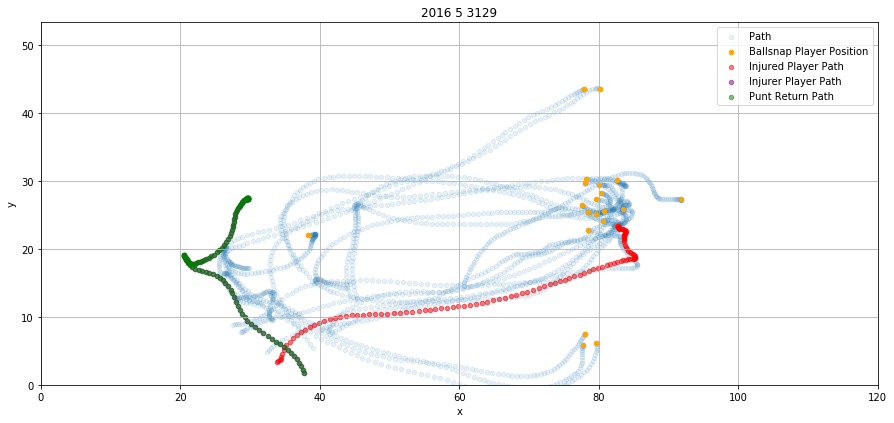

============= plotting play in position: 1
YEAR 2016 GAMEKEY 21 PLAYID 2587
(5:52) (Punt formation) K.Redfern punts 36 yards to TEN 9, Center-J.Jansen, downed by CAR-B.Wegher. PENALTY on TEN-M.Huff, Illegal Blindside Block, 5 yards, enforced at TEN 9.
[None 'ball_snap' 'punt' 'punt_downed' 'penalty_flag' 'punt_play'
 'line_set' 'penalty_accepted' 'play_submit']
injured player:  29343 - player role GL


injuring player: 31059.0 - player role PLL1
punt returner: 33132.0
friendly_fire: No


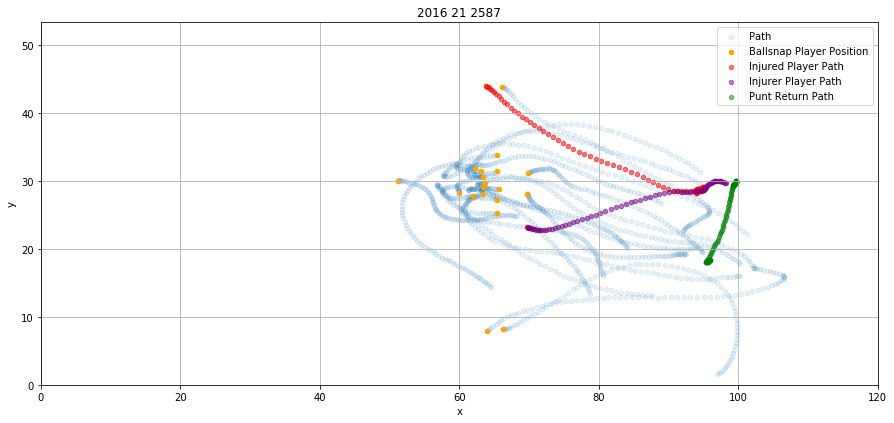

============= plotting play in position: 2
YEAR 2016 GAMEKEY 29 PLAYID 538
(4:46) L.Edwards punts 51 yards to WAS 27, Center-T.Purdum. J.Crowder MUFFS catch, touched at WAS 27, recovered by WAS-Q.Dunbar at WAS 11. Q.Dunbar to WAS 11 for no gain (M.Williams).
[None 'fumble' 'fumble_offense_recovered' 'tackle' 'punt_play' 'line_set'
 'punt' 'punt_received' 'play_submit' 'ball_snap']
injured player:  31023 - player role GR


injuring player: 31941.0 - player role PR
punt returner: 31941.0
friendly_fire: No


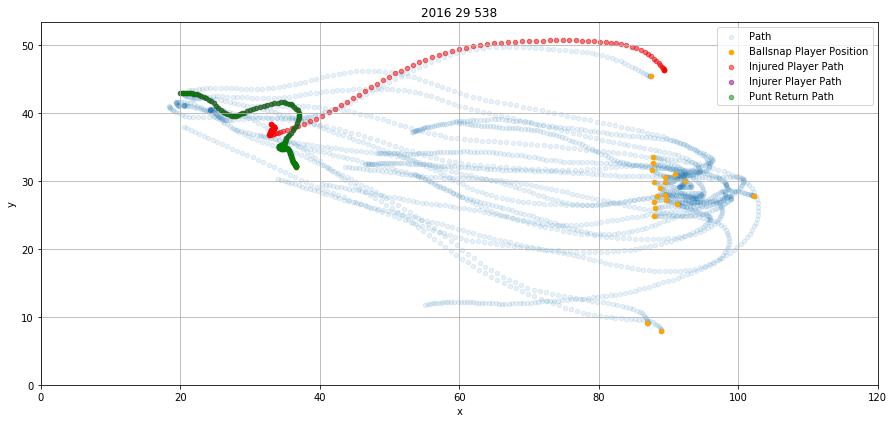

============= plotting play in position: 3
YEAR 2016 GAMEKEY 45 PLAYID 1212
(8:29) B.Wing punts 44 yards to NYJ 10, Center-T.Ott. J.Ross to NYJ 38 for 28 yards (O.Darkwa; B.Goodson).
[None 'punt' 'line_set' 'ball_snap' 'punt_received' 'punt_play' 'tackle'
 'play_submit']
injured player:  33121 - player role PRT


injuring player: 28249.0 - player role PR
punt returner: 28249.0
friendly_fire: No


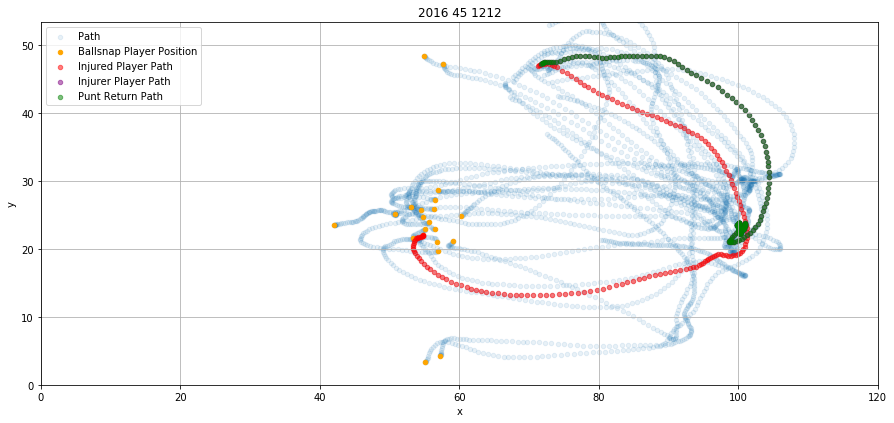

============= plotting play in position: 4
YEAR 2016 GAMEKEY 54 PLAYID 1045
(9:57) J.Berry punts 45 yards to CAR 31, Center-G.Warren. D.Byrd to CAR 46 for 15 yards (S.Davis).
[None 'punt_received' 'tackle' 'play_submit' 'punt_play' 'line_set'
 'ball_snap' 'punt']
injured player:  32444 - player role PRT


injuring player: 31756.0 - player role GR
punt returner: 31868.0
friendly_fire: Yes


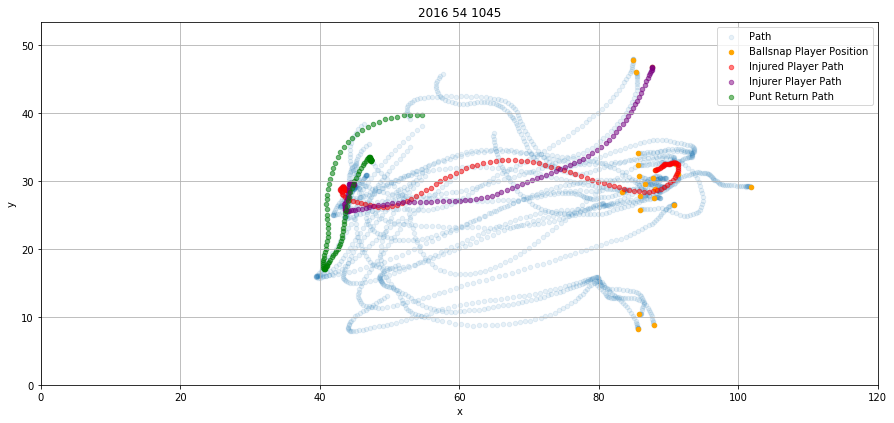

============= plotting play in position: 5
YEAR 2016 GAMEKEY 60 PLAYID 905
(:38) C.Schmidt punts 46 yards to DET 8, Center-G.Sanborn. J.Billingsley to DET 13 for 5 yards (M.Lawson). PENALTY on DET-D.Walls, Illegal Block Above the Waist, 3 yards, enforced at DET 7.
[None 'line_set' 'ball_snap' 'tackle' 'penalty_flag' 'punt_play' 'punt'
 'punt_received' 'penalty_accepted' 'play_submit']
injured player:  30786 - player role PRW


injuring player: 29815.0 - player role PDL1
punt returner: 32553.0
friendly_fire: No


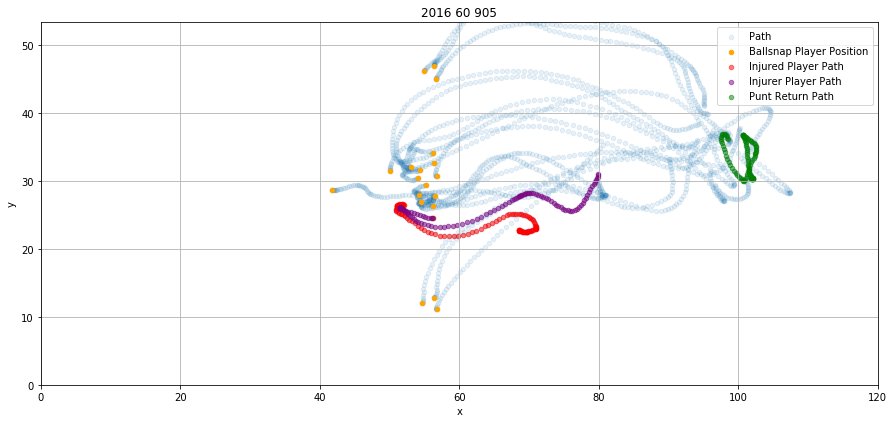

============= plotting play in position: 6
YEAR 2016 GAMEKEY 144 PLAYID 2342
(13:21) C.Schmidt punts 54 yards to SF 19, Center-G.Sanborn. J.Kerley to SF 31 for 12 yards (M.Gillislee).
[None 'ball_snap' 'line_set' 'punt_received' 'punt' 'play_submit' 'tackle'
 'punt_play']
injured player:  32410 - player role VR


injuring player: 23259.0 - player role PLG
punt returner: 28091.0
friendly_fire: No


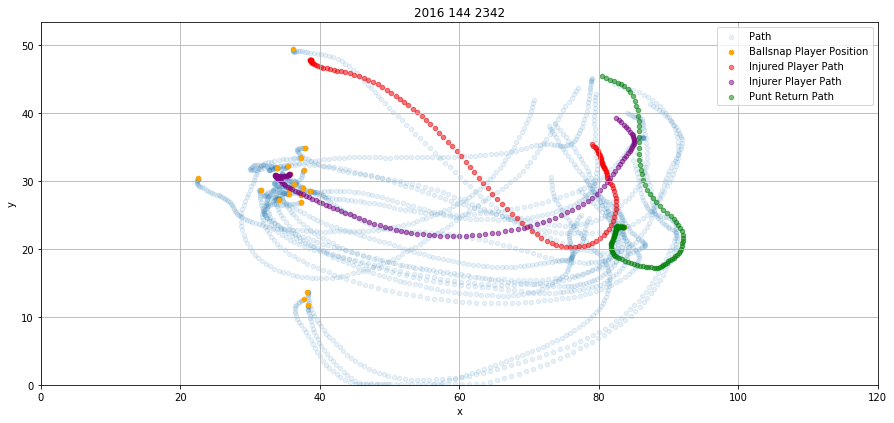

============= plotting play in position: 7
YEAR 2016 GAMEKEY 149 PLAYID 3663
(1:07) T.Morstead punts 54 yards to CAR 39, Center-J.Drescher. T.Ginn to 50 for 11 yards (D.Lasco).
[None 'punt' 'line_set' 'punt_play' 'punt_received' 'ball_snap' 'tackle'
 'play_submit']
injured player:  28128 - player role PFB


injuring player: 29629.0 - player role PRT
punt returner: 25396.0
friendly_fire: No


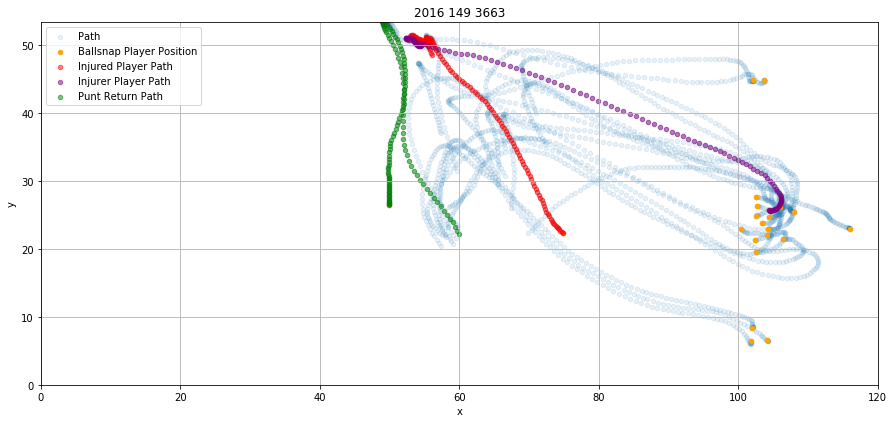

============= plotting play in position: 8
YEAR 2016 GAMEKEY 189 PLAYID 3509
(6:46) D.Colquitt punts 54 yards to JAX 31, Center-J.Winchester. B.Walters to JAX 39 for 8 yards (F.Zombo).
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received' 'tackle'
 'play_submit']
injured player:  27595 - player role PR


injuring player: 31950.0 - player role PRG
punt returner: 27595.0
friendly_fire: No


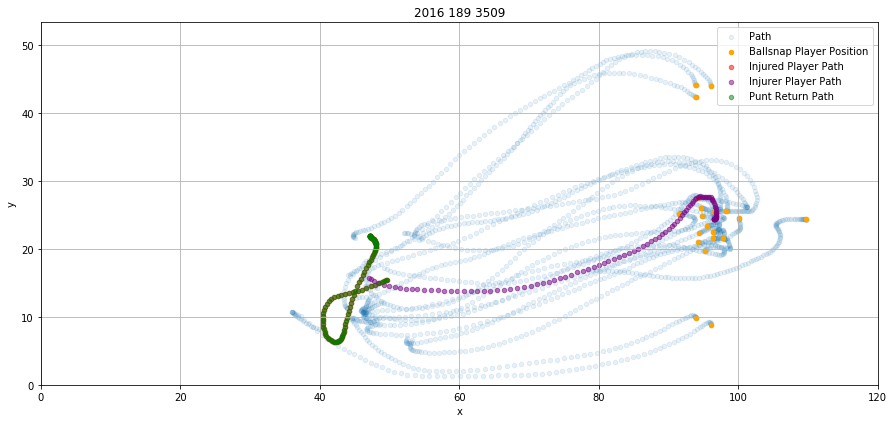

============= plotting play in position: 9
YEAR 2016 GAMEKEY 218 PLAYID 3468
(8:03) (Punt formation) B.Kern punts 46 yards to IND 37, Center-B.Brinkley. C.Rogers to IND 39 for 2 yards (W.Woodyard).
[None 'line_set' 'punt_play' 'punt' 'ball_snap' 'tackle' 'punt_received'
 'play_submit']
injured player:  28987 - player role PLG


no injuring player
punt returner: 32355.0
friendly_fire: nan
no injuring player


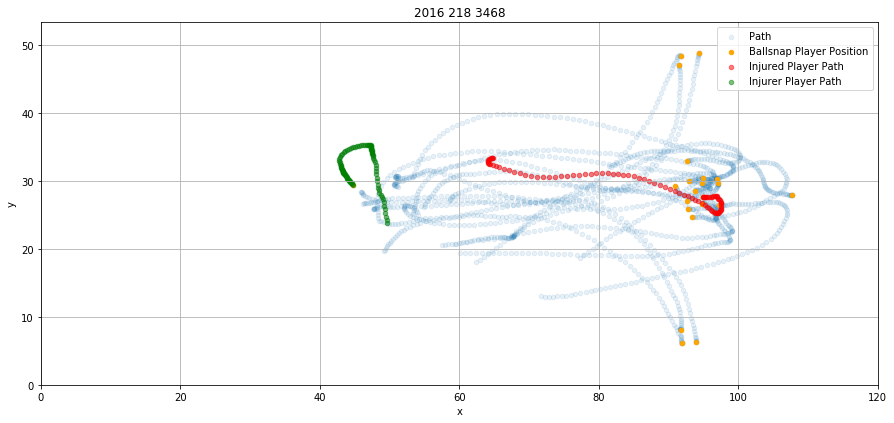

============= plotting play in position: 10
YEAR 2016 GAMEKEY 231 PLAYID 1976
(1:15) (Punt formation) K.Huber punts 58 yards to BLT 14, Center-T.Ott. D.Hester MUFFS catch, and recovers at BLT 12. D.Hester pushed ob at BLT 27 for 15 yards (N.Vigil). CIN-C.Brown was injured during the play. 
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received'
 'out_of_bounds' 'play_submit']
injured player:  32214 - player role PLG


injuring player: 32807.0 - player role PRW
punt returner: 24272.0
friendly_fire: Yes


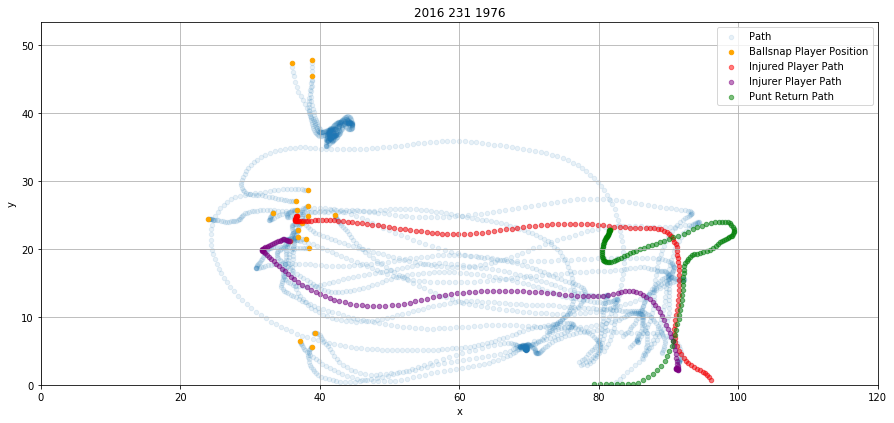

============= plotting play in position: 11
YEAR 2016 GAMEKEY 234 PLAYID 3278
(13:00) (Punt formation) B.Wing punts 43 yards to CLV 5, Center-Z.DeOssie, downed by NYG-D.Harris. NYG-M.Herzlich was injured during the play. His return is Questionable. 
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_downed'
 'play_submit']
injured player:  28620 - player role PRG


injuring player: 27860.0 - player role PR
punt returner: 27860.0
friendly_fire: No


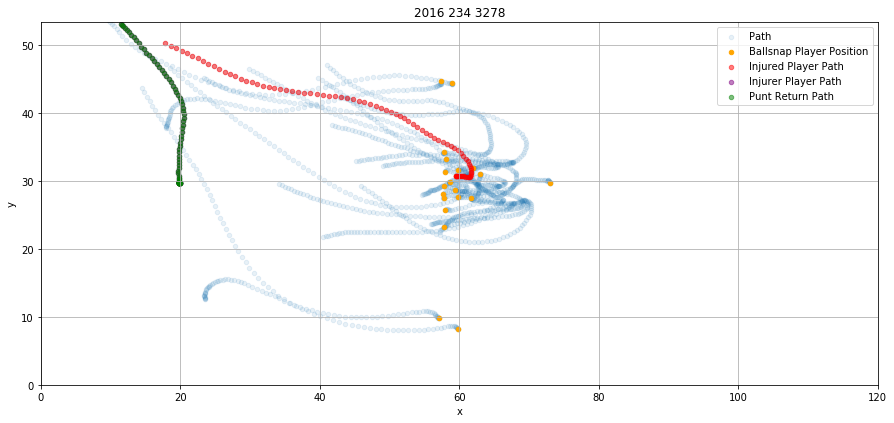

============= plotting play in position: 12
YEAR 2016 GAMEKEY 266 PLAYID 2902
(11:38) T.Way punts 45 yards to PHI 25, Center-N.Sundberg, downed by WAS. PHI-D.Sproles was injured during the play.  PENALTY on WAS-D.Everett, Interference with Opportunity to Catch, 15 yards, enforced at PHI 25.
[None 'line_set' 'ball_snap' 'punt' 'kick_received' 'fumble'
 'fumble_offense_recovered' 'tackle' 'penalty_flag' 'penalty_accepted'
 'play_submit']
injured player:  23564 - player role PR


injuring player: 31844.0 - player role GR
punt returner: 23564.0
friendly_fire: No


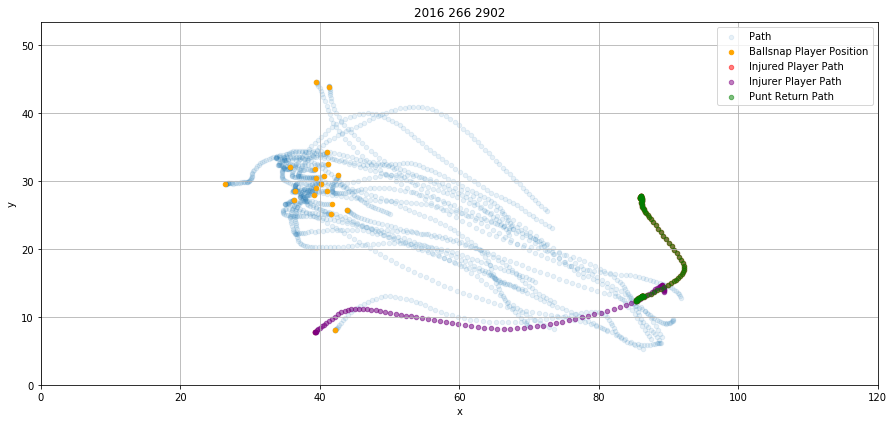

============= plotting play in position: 13
YEAR 2016 GAMEKEY 274 PLAYID 3609
(5:22) (Punt formation) J.Ryan up the middle to LA 47 for 26 yards. FUMBLES, recovered by SEA-N.Thorpe at LA 40. SEA-J.Ryan was injured during the play.  Los Angeles challenged the loose ball recovery ruling, and the play was Upheld. The ruling on the field stands. (Timeout #2.)
[None 'punt_play' 'line_set' 'ball_snap' 'punt_fake' 'run' 'fumble'
 'fumble_offense_recovered' 'tackle' 'play_submit']
injured player:  23742 - player role P


injuring player: 31785.0 - player role VLo
punt returner: 30525.0
friendly_fire: No


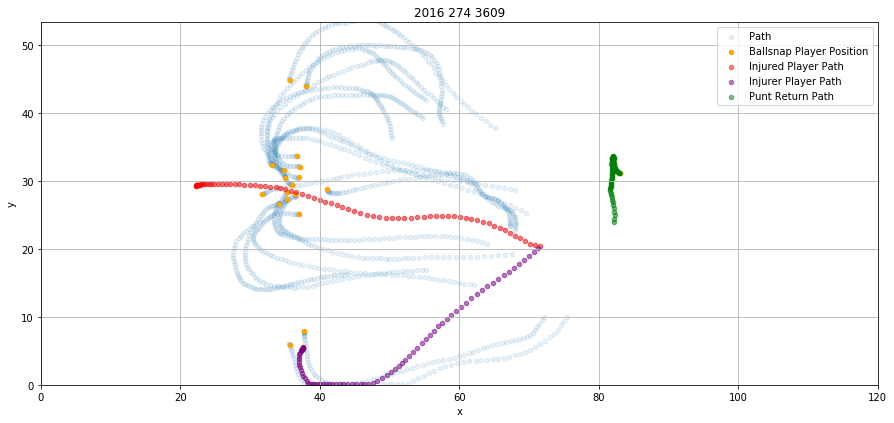

============= plotting play in position: 14
YEAR 2016 GAMEKEY 280 PLAYID 2918
(3:36) B.Nortman punts 49 yards to HST 30, Center-C.Tinker, fair catch by W.Fuller.
[None 'play_submit' 'punt_play' 'line_set' 'ball_snap' 'punt' 'fair_catch']
injured player:  32120 - player role PLW


injuring player: 32725.0 - player role PDR1
punt returner: 33127.0
friendly_fire: No


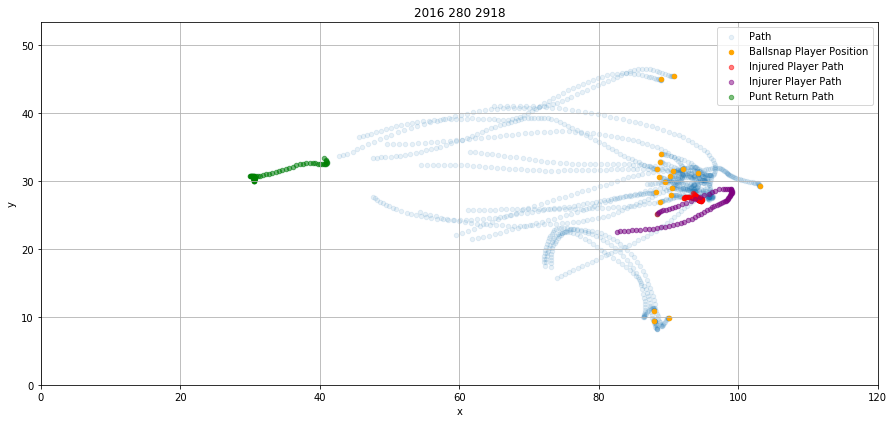

============= plotting play in position: 15
YEAR 2016 GAMEKEY 280 PLAYID 3746
(5:57) B.Nortman punts 41 yards to HST 44, Center-C.Tinker. W.Fuller to HST 48 for 4 yards (A.Benn).
[None 'play_submit' 'punt_play' 'line_set' 'ball_snap' 'punt'
 'punt_received' 'tackle']
injured player:  27654 - player role GL


injuring player: 33127.0 - player role PR
punt returner: 33127.0
friendly_fire: No


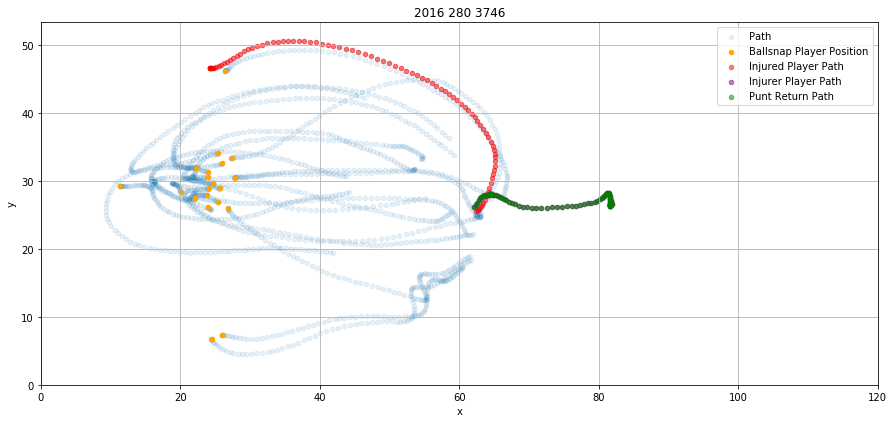

============= plotting play in position: 16
YEAR 2016 GAMEKEY 281 PLAYID 1526
(1:52) B.Kern punts 38 yards to TEN 48, Center-B.Brinkley. T.Hill to TEN 45 for 3 yards (N.Palmer; A.Andrews).
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received' 'tackle'
 'play_submit']
injured player:  28987 - player role PLG


injuring player: 30789.0 - player role PLW
punt returner: 33040.0
friendly_fire: Yes


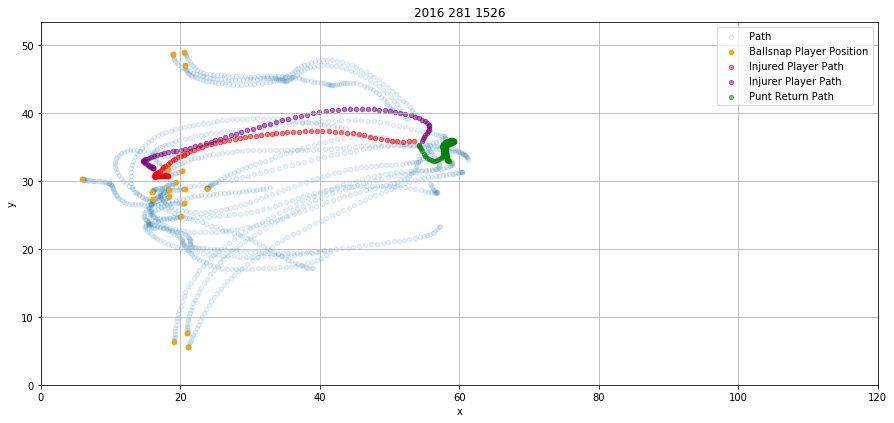

============= plotting play in position: 17
YEAR 2016 GAMEKEY 289 PLAYID 2341
(12:41) T.Way punts 51 yards to CAR 23, Center-N.Sundberg. T.Ginn pushed ob at CAR 42 for 19 yards (T.Garvin). WAS-Q.Dunbar was injured during the play. He is Out.  47- Dunbar is being evaluated for a concussion
[None 'play_submit' 'punt_play' 'line_set' 'ball_snap' 'punt'
 'punt_received' 'out_of_bounds']
injured player:  32007 - player role GL


injuring player: 32998.0 - player role PDR3
punt returner: 25396.0
friendly_fire: No


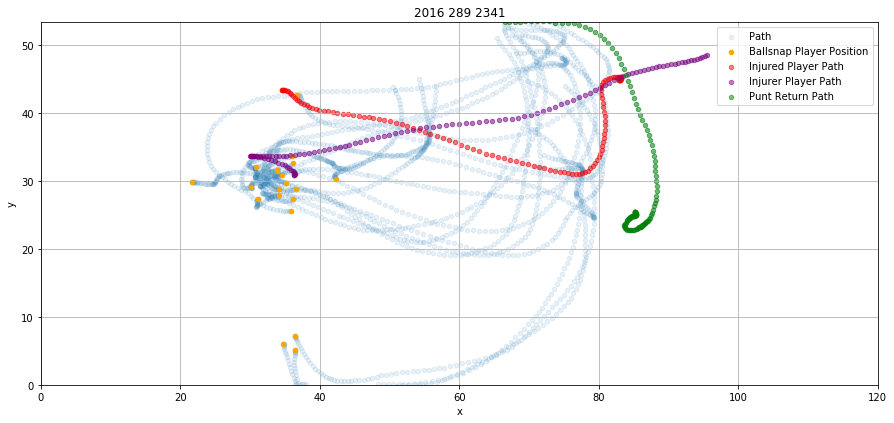

============= plotting play in position: 18
YEAR 2016 GAMEKEY 296 PLAYID 2667
(6:11) B.Kern punts 43 yards to JAX 23, Center-B.Brinkley. B.Walters to JAX 23 for no gain (K.Reed; L.Sims).
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received' 'tackle'
 'play_submit']
injured player:  32783 - player role GL


injuring player: 32810.0 - player role GR
punt returner: 27595.0
friendly_fire: Yes


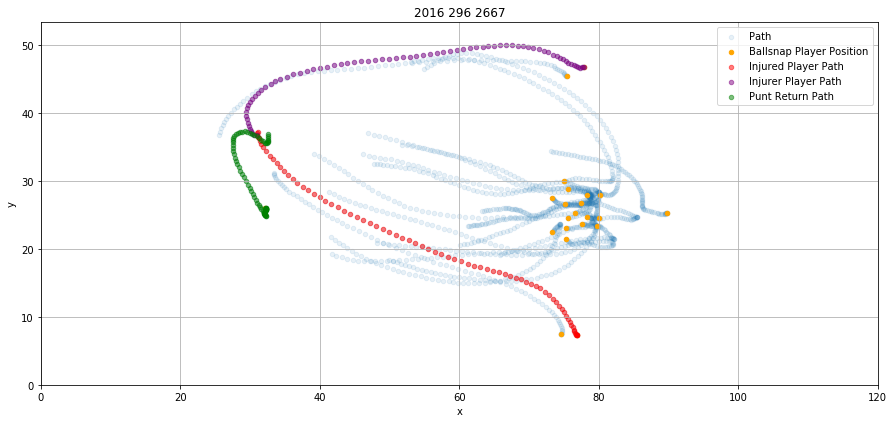

============= plotting play in position: 19
YEAR 2017 GAMEKEY 357 PLAYID 3630
(13:22) (Punt formation) M.Haack punts 52 yards to BLT 25, Center-W.Chapman. B.Rainey to BLT 34 for 9 yards (D.Morgan). MIA-C.Pantale was injured during the play. His return is Questionable. 
[None 'ball_snap' 'punt' 'punt_received' 'first_contact' 'punt_play'
 'tackle' 'play_submit' 'line_set']
injured player:  30171 - player role PRG


injuring player: 29384.0 - player role PR
punt returner: 29384.0
friendly_fire: No


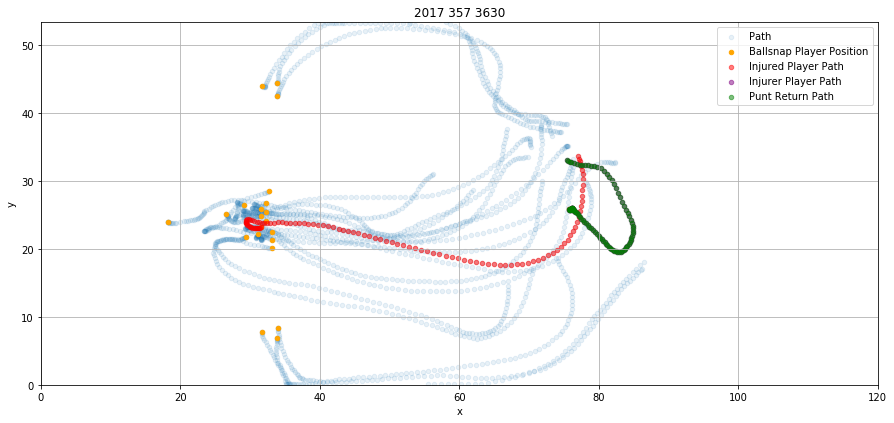

============= plotting play in position: 20
YEAR 2017 GAMEKEY 364 PLAYID 2489
(11:50) J.Vogel punts 44 yards to WAS 32, Center-D.Hart. K.Fuller to WAS 37 for 5 yards (K.King). PENALTY on WAS-J.Harvey-Clemons, Offensive Holding, 10 yards, enforced at WAS 31.
[None 'punt_play' 'huddle_start_offense' 'huddle_break_offense' 'line_set'
 'ball_snap' 'punt' 'punt_received' 'first_contact' 'tackle'
 'penalty_accepted' 'play_submit']
injured player:  31313 - player role PLT


injuring player: 32851.0 - player role PDR2
punt returner: 33084.0
friendly_fire: No


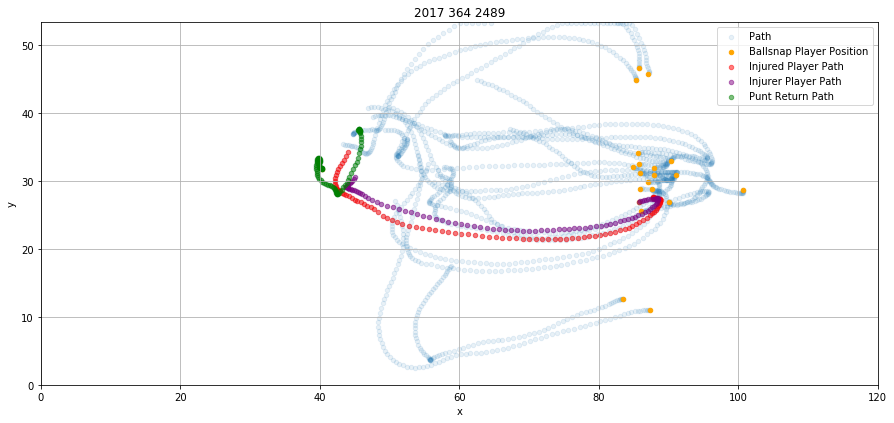

============= plotting play in position: 21
YEAR 2017 GAMEKEY 364 PLAYID 2764
(8:23) J.Vogel punts 43 yards to WAS 48, Center-D.Hart. K.Fuller to GB 40 for 12 yards (J.Hawkins).
[None 'punt_received' 'first_contact' 'tackle' 'play_submit' 'punt_play'
 'line_set' 'ball_snap' 'punt']
injured player:  32323 - player role PLG


injuring player: 31930.0 - player role PDR1
punt returner: 33084.0
friendly_fire: No


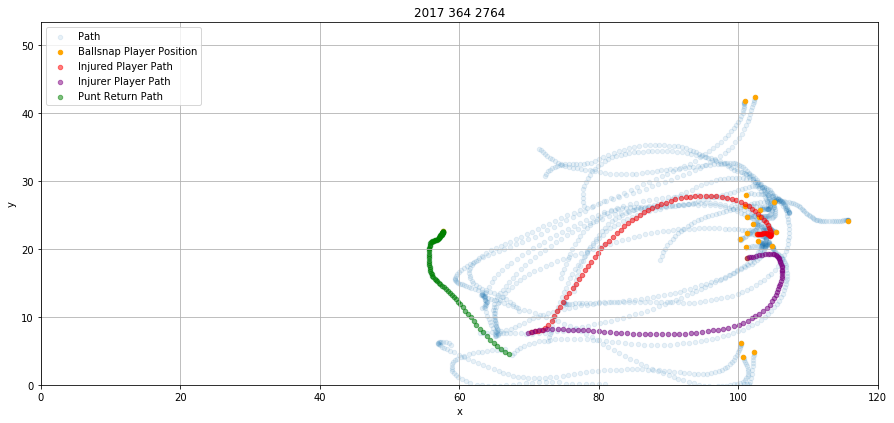

============= plotting play in position: 22
YEAR 2017 GAMEKEY 384 PLAYID 183
(12:29) B.Nortman punts 40 yards to ATL 25, Center-M.Overton. J.Hardy to ATL 32 for 7 yards (B.Brown). JAX-J.Harper was injured during the play.  PENALTY on ATL-J.Keyes, Offensive Holding, 10 yards, enforced at ATL 25.
[None 'line_set' 'punt_play' 'punt' 'ball_snap' 'tackle' 'punt_received'
 'penalty_flag' 'first_contact' 'penalty_accepted' 'play_submit']
injured player:  33813 - player role PPR


injuring player: 33841.0 - player role PLT
punt returner: 31570.0
friendly_fire: Yes


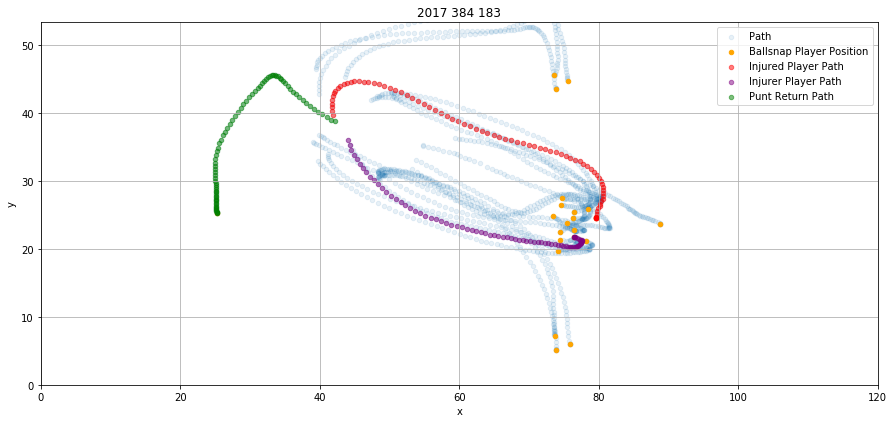

============= plotting play in position: 23
YEAR 2017 GAMEKEY 392 PLAYID 1088
(9:57) B.Kern punts 61 yards to KC 24, Center-R.DiSalvo. J.Chesson for 76 yards, TOUCHDOWN. TEN-R.DiSalvo was injured during the play. 
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received'
 'touchdown' 'play_submit']
injured player:  32615 - player role PLS


injuring player: 31999.0 - player role PDL1
punt returner: 33464.0
friendly_fire: No


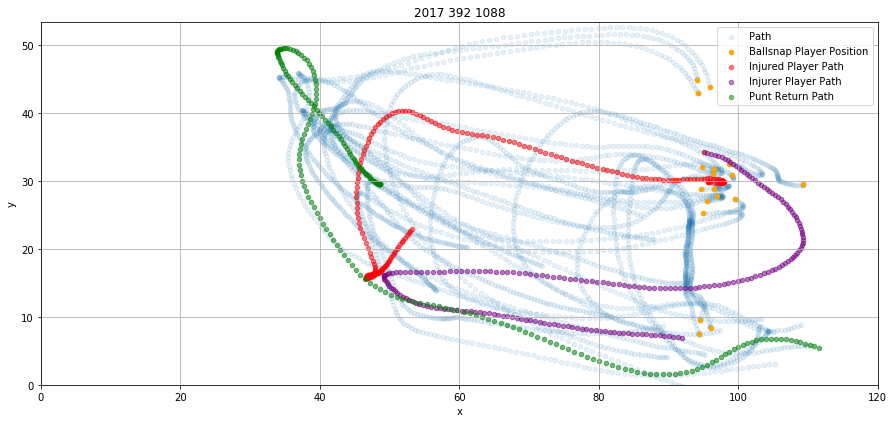

============= plotting play in position: 24
YEAR 2017 GAMEKEY 397 PLAYID 1526
(2:10) T.Baker punts 41 yards to SF 11, Center-M.Windt. D.Carter to SF 14 for 3 yards (J.Perry; D.Brown).
[None 'line_set' 'punt_play' 'punt_received' 'ball_snap' 'punt' 'tackle'
 'first_contact' 'play_submit']
injured player:  32894 - player role PLT


injuring player: 31763.0 - player role PR
punt returner: 31763.0
friendly_fire: No


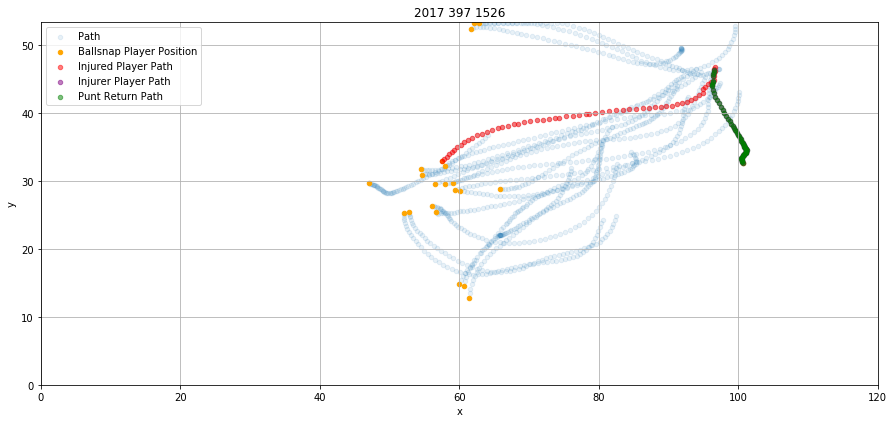

============= plotting play in position: 25
YEAR 2017 GAMEKEY 399 PLAYID 3312
(3:22) D.Colquitt punts 36 yards to KC 47, Center-J.Winchester. D.Amendola to KC 44 for 3 yards (T.Smith). PENALTY on NE-B.Bolden, Running Into the Kicker, 5 yards, enforced at KC 11 - No Play.
[None 'play_submit' 'penalty_accepted' 'punt_play' 'ball_snap' 'line_set'
 'punt_received' 'punt' 'first_contact' 'tackle' 'penalty_flag']
injured player:  26035 - player role PR


injuring player: 27442.0 - player role PRT
punt returner: 26035.0
friendly_fire: No


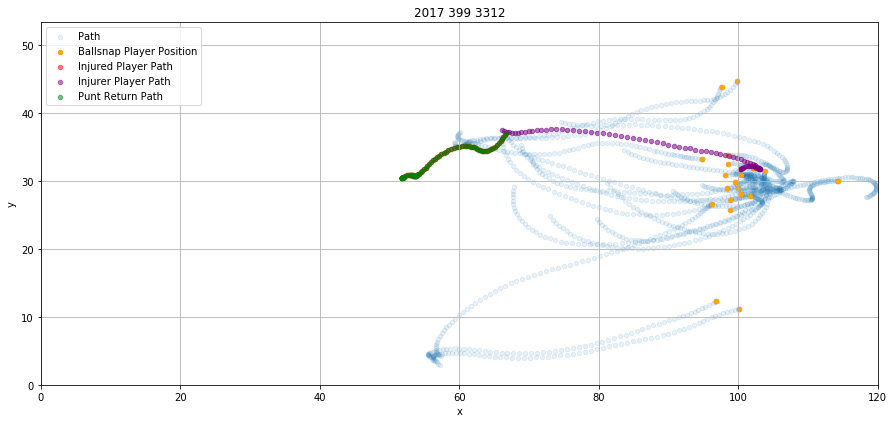

============= plotting play in position: 26
YEAR 2017 GAMEKEY 414 PLAYID 1262
(10:20) D.Kaser punts 59 yards to DEN 13, Center-M.Windt. I.McKenzie ran ob at DEN 44 for 31 yards.
[None 'line_set' 'ball_snap' 'punt' 'punt_received' 'out_of_bounds'
 'play_submit']
injured player:  33941 - player role PLW


no injuring player
punt returner: 33466.0
friendly_fire: nan
no injuring player


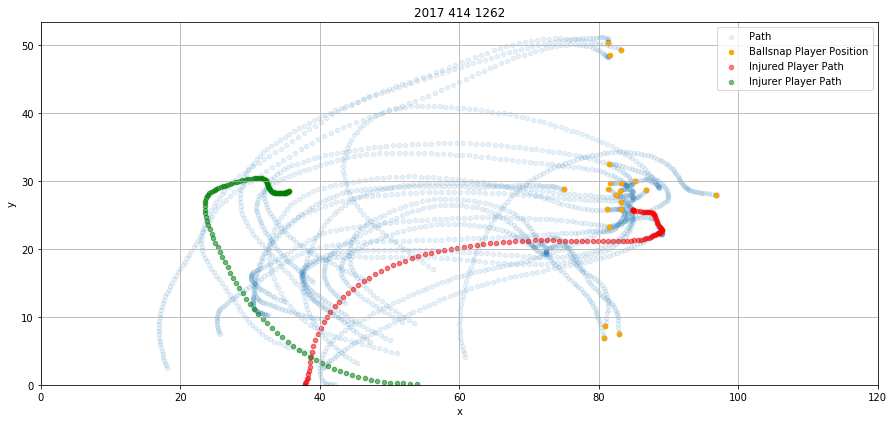

============= plotting play in position: 27
YEAR 2017 GAMEKEY 448 PLAYID 2792
(4:19) (Punt formation) M.Haack punts 42 yards to NO 30, Center-J.Denney. T.Ginn ran ob at NO 39 for 9 yards (J.Denney).
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received'
 'out_of_bounds' 'play_submit']
injured player:  33838 - player role PDR1


injuring player: 31317.0 - player role PRG
punt returner: 25396.0
friendly_fire: No


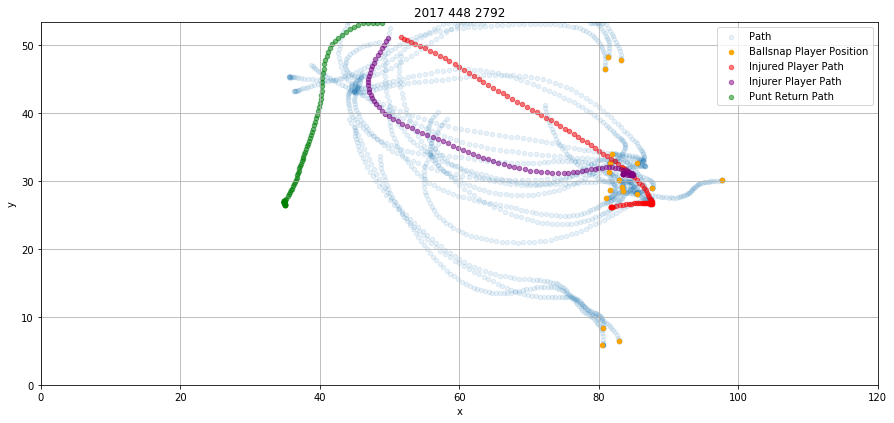

============= plotting play in position: 28
YEAR 2017 GAMEKEY 473 PLAYID 2072
(9:49) M.King punts 62 yards to BLT 15, Center-J.Condo. M.Campanaro to BLT 24 for 9 yards (J.Condo, J.Cowser).
[None 'punt_play' 'line_set' 'ball_snap' 'punt' 'punt_received'
 'first_contact' 'tackle' 'play_submit']
injured player:  29492 - player role PRG


injuring player: 33445.0 - player role PLT
punt returner: 31025.0
friendly_fire: Yes


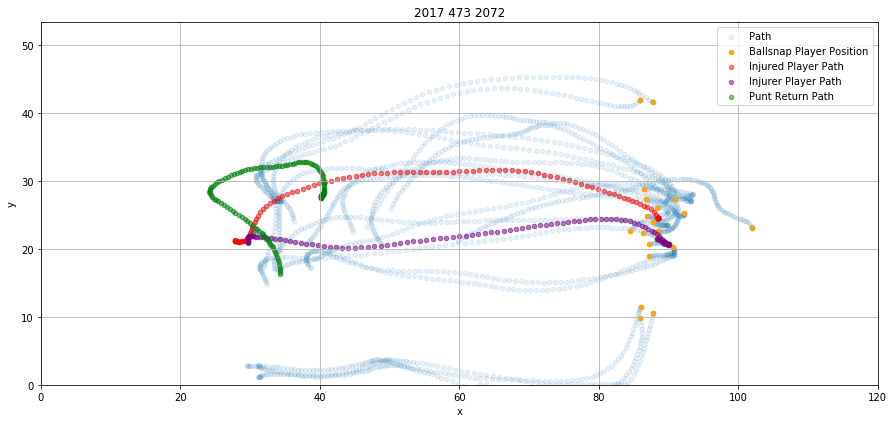

============= plotting play in position: 29
YEAR 2017 GAMEKEY 506 PLAYID 1988
(1:12) (Punt formation) M.Haack punts 41 yards to BLT 29, Center-J.Denney. L.Webb to BLT 29 for no gain.
[None 'line_set' 'ball_snap' 'punt' 'punt_land' 'punt_play' 'fair_catch'
 'play_submit']
injured player:  27060 - player role PR


no injuring player
punt returner: 27060.0
friendly_fire: No
no injuring player


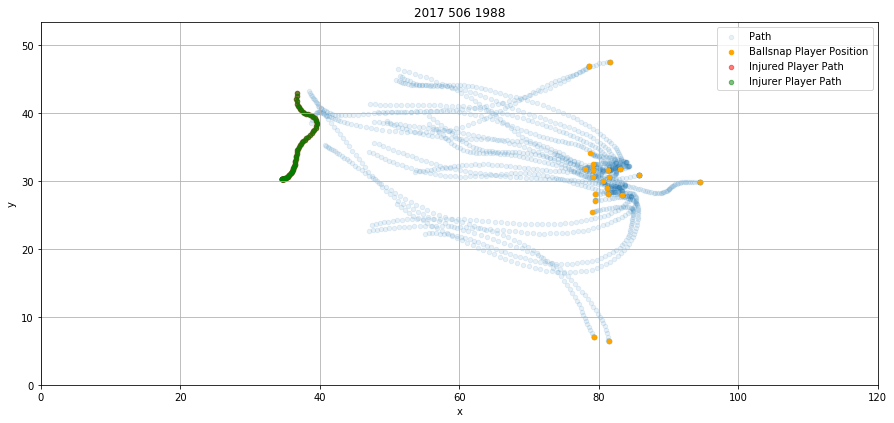

============= plotting play in position: 30
YEAR 2017 GAMEKEY 553 PLAYID 1683
(1:10) B.Wing punts 37 yards to KC 29, Center-Z.DeOssie. T.Hill pushed ob at KC 49 for 20 yards (N.Berhe). Penalty on KC-F.Zombo, Offensive Holding, declined. PENALTY on KC-T.Smith, Unnecessary Roughness, 15 yards, enforced at KC 33. Officially, a return for 4 yards.
[None 'penalty_flag' 'punt' 'punt_received' 'out_of_bounds' 'punt_play'
 'line_set' 'ball_snap' 'play_submit' 'penalty_declined'
 'penalty_accepted']
injured player:  32820 - player role PDL2


injuring player: 25503.0 - player role PLS
punt returner: 33040.0
friendly_fire: No


============= plotting play in position: 31
YEAR 2017 GAMEKEY 567 PLAYID 1407
(7:18) M.Palardy punts 53 yards to NYJ 17, Center-J.Jansen. J.Natson to NYJ 10 for -7 yards (S.Thompson).
[None 'punt_play' 'ball_snap' 'punt' 'punt_received' 'first_contact'
 'tackle' 'play_submit']
injured player:  32403 - player role PLL


injuring player: 32891.0 - player role GR
punt returner: 33266.0
friendly_fire: No


============= plotting play in position: 32
YEAR 2017 GAMEKEY 585 PLAYID 2208
(13:36) (Punt formation) B.Kern punts 55 yards to HST 18, Center-B.Brinkley. B.Miller ran ob at HST 26 for 8 yards (E.Weems).
[None 'ball_snap' 'punt' 'punt_received' 'punt_play' 'line_set'
 'out_of_bounds' 'play_submit']
injured player:  33069 - player role PR


injuring player: 24535.0 - player role PPR
punt returner: 33069.0
friendly_fire: No


============= plotting play in position: 33
YEAR 2017 GAMEKEY 585 PLAYID 733
(2:57) (Punt formation) S.Lechler punts 48 yards to TEN 16, Center-J.Weeks. A.Jackson pushed ob at TEN 32 for 16 yards (J.Jenkins). PENALTY on TEN-J.Brown, Illegal Block Above the Waist, 10 yards, enforced at TEN 32.
[None 'punt_play' 'penalty_flag' 'play_submit' 'line_set' 'ball_snap'
 'punt' 'punt_received' 'first_contact' 'out_of_bounds' 'penalty_accepted']
injured player:  30384 - player role PRW


no injuring player
punt returner: 33878.0
friendly_fire: Unclear
no injuring player


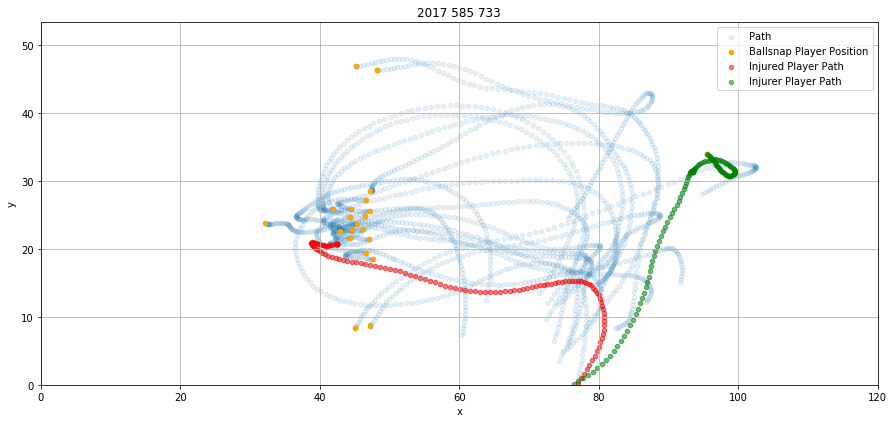

============= plotting play in position: 34
YEAR 2017 GAMEKEY 601 PLAYID 602
(5:56) L.Edwards punts 47 yards to DEN 37, Center-T.Hennessy. J.Taylor to DEN 49 for 12 yards (J.Burris; T.Hennessy). NYJ-T.Hennessy was injured during the play. His return is Probable. 
[None 'line_set' 'punt' 'ball_snap' 'first_contact' 'punt_received'
 'play_submit' 'tackle']
injured player:  33260 - player role PLS


injuring player: 31697.0 - player role PR
punt returner: 31697.0
friendly_fire: No


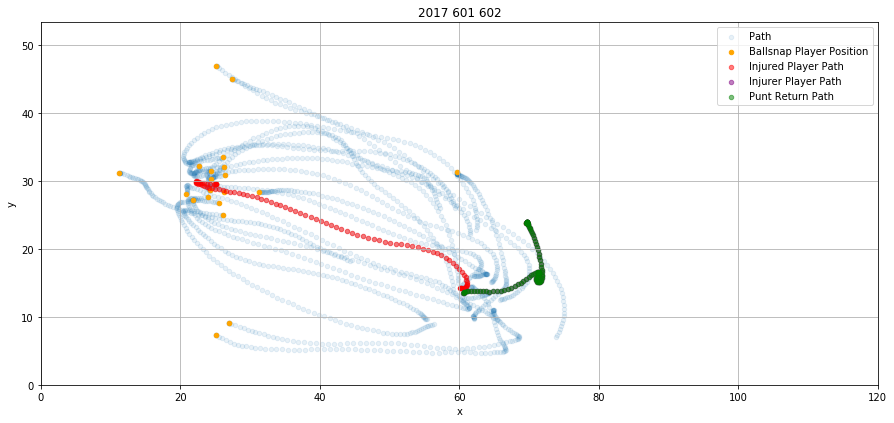

============= plotting play in position: 35
YEAR 2017 GAMEKEY 607 PLAYID 978
(14:11) (Punt formation) R.Sanchez punts 27 yards to DEN 11, Center-L.Rhodes, fair catch by J.Taylor. IND-B.Williams was injured during the play. He is Out.  PENALTY on IND-C.Milton, Fair Catch Interference, 15 yards, enforced at DEN 11.
[None 'penalty_flag' 'fair_catch' 'punt' 'punt_play' 'ball_snap'
 'line_set' 'play_submit' 'penalty_accepted']
injured player:  29793 - player role PLW


injuring player: 32114.0 - player role PDR2
punt returner: 31697.0
friendly_fire: No


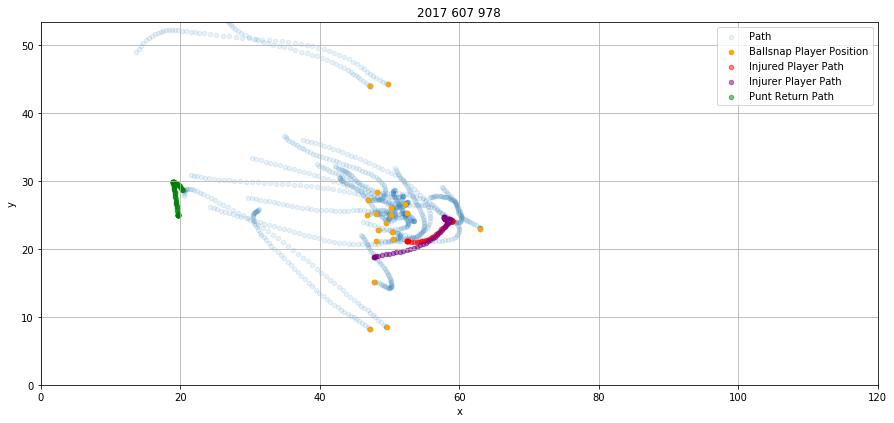

============= plotting play in position: 36
YEAR 2017 GAMEKEY 618 PLAYID 2792
(5:39) J.Ryan punts 61 yards to LA 13, Center-T.Ott. P.Cooper to LA 22 for 9 yards (B.McDougald; D.Alexander).
[None 'play_submit' 'punt_play' 'line_set' 'ball_snap' 'punt'
 'punt_received' 'first_contact' 'out_of_bounds']
injured player:  31950 - player role PRG


injuring player: 32677.0 - player role PDR1
punt returner: 33111.0
friendly_fire: No


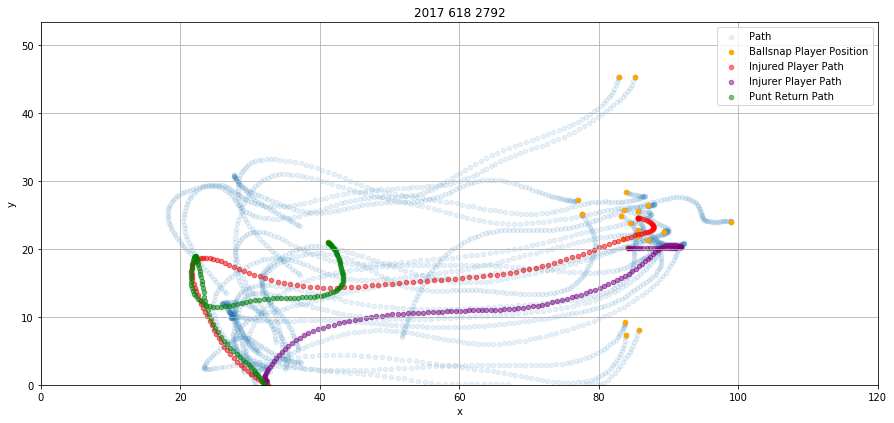

In [47]:
axes = []
for i in range(37):
    print('============= plotting play in position: {}'.format(i))
    vr_num = i # 0 to 37
    season_year = vr.loc[vr_num]['season_year']
    gamekey = vr.loc[vr_num]['gamekey']
    playid = vr.loc[vr_num]['playid']
    axes.append(plot_injured_play(season_year = season_year, gamekey = gamekey, playid = playid))
    plt.show()

# Plotting Plays Interactive

In [46]:
output_notebook()

playinfo = Div(text='Play info', width=200, height=100)

# Filter a sepcific play
season_year=2016
gamekey=21
playid=2587

play = ngs[(ngs['season_year'] == season_year) &
           (ngs['gamekey'] == gamekey) &
           (ngs['playid'] == playid)]

play = pd.merge(play, pprd)
playxy = play.drop(['season_year','gamekey'], axis=1) \
    .pivot(index='time',
           columns='role',
           values=['x','y','event'])

# Create colors
colors = ['red' if x in(vr['gsisid'].values) or x in(vr['primary_partner_gsisid'].values) else 'blue' for x in play.gsisid.unique()]

# Setup Figure
## Football Field Figure
fig = figure(plot_width=800, plot_height=400, x_range=(0,120), y_range=(0, 53.3))
fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# Green Field
box = BoxAnnotation(left=0, right=120, fill_color='green', fill_alpha=0.5)
endzone1 = BoxAnnotation(left=0, right=10, fill_color='grey', fill_alpha=0.5)
endzone2 = BoxAnnotation(left=110, right=120, fill_color='grey', fill_alpha=0.5)
fig.add_layout(box)
fig.add_layout(endzone1)
fig.add_layout(endzone2)
# Add lines|
fig.line([10,10,20,20,30,30,40,40,50,50,60,60,70,70,80,80,90,90,
          100,100,110,110,120,120],
         [55.5,0,0,55.5,55.5,0,0,55.5,55.5,0,0,55.5,55.5,0,0,55.5,
         55.5,0,0,55.5,55.5,0,0,0], line_color='grey')
# Line numbers

line_nums = ColumnDataSource(dict(x=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                                  y=[5, 5, 5, 5, 5, 5, 5, 5, 5],
                                  text=['10', '20', '30','40','50','40','30','20','10']))
glyph = Text(x="x", y="y", text="text", angle=0, text_color="black", text_align='center')
fig.add_glyph(line_nums, glyph)

# Create values used in the initial states
x_values = playxy.loc[playxy.index[1]]['x'].values
y_values = playxy.loc[playxy.index[1]]['y'].values
gsisid = playxy['x'].columns.values
source = ColumnDataSource(data=dict(x=x_values,
                                    y=y_values,
                                    gsisid=gsisid))
labels = LabelSet(x='x', y='y', text='gsisid', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

# Add players as circles
plt = fig.circle(x_values, y_values, size=20, alpha=0.5, color=colors, radius=1)
fig.add_layout(labels)

def plot_time_pos(time_pos):
    x_values = playxy.loc[playxy.index[time_pos]]['x'].values
    y_values = playxy.loc[playxy.index[time_pos]]['y'].values
    gsisid = playxy['x'].columns.values
    # p = figure(plot_width=800, plot_height=400)
    # p.circle(x_values, y_values, size=20, color="navy", alpha=0.5)
    source = ColumnDataSource(data=dict(x=x_values,
                                    y=y_values,
                                    gsisid=gsisid))
    labels = LabelSet(x='x', y='y', text='gsisid', level='glyph',
               x_offset=5, y_offset=5, source=source, render_mode='canvas')
    fig.renderers.pop()
    fig.add_layout(labels)
    plt.data_source.data['x'] = x_values
    plt.data_source.data['y'] = y_values

    # Update text
    event = playxy.loc[playxy.index[time_pos]]['event'].values[0]
    playinfo.text = str(event)
    
    push_notebook(handle=bokeh_handle)


source = ColumnDataSource(data=dict(x=x_values, y=y_values))

callback = CustomJS(code="""
if (IPython.notebook.kernel !== undefined) {
    var kernel = IPython.notebook.kernel;
    cmd = "plot_time_pos(" + cb_obj.value + ")";
    kernel.execute(cmd, {}, {});
}
""")


slider = Slider(start=0,
                end=len(playxy),
                value=1,
                step=1,
                title="position within play",
                callback=callback)

layout = column(
    widgetbox(slider),
    fig,
    playinfo
)

bokeh_handle = show(layout, notebook_handle=True)

Loading BokehJS ...